# Simulate effect of squeezed momentum and position states.

In [128]:
# import two_atom_interaction.py
from two_atom_interaction import *
# keep track of time
import time

### non-squeezed position and momentum spread.

In [ ]:
# first checking without squeezing what is the position and momentum spread
pixel_to_um = 0.87 # imaging system calibration from Cs-Cs (Na-Cs gives ~ 0.87)
# pixel_to_um = 0.87

# Experiment configuration
cfg_no_squeeze = ExperimentConfig(
    R_mean_um = 6.5 * pixel_to_um,  # mean interatomic distance in microns
    R_axis_um = (1.0, 0.0, 0.0),  # along x-axis
    OMEGA_atom1_Hz = 5.0e5,  # Na Rabi frequency (Hz)
    OMEGA_atom2_Hz = 0,  # Cs Rabi frequency (Hz) [no Cs drive] - just prepare Cs in Rydberg

    Delta_scan_Hz = np.linspace(-1, 3, 30) * 1e6, # detuning scan range (Hz)

    # Order: (x, y, z). (radial, radial, axial)
    # These are the *ground-state* trap temps of each tweezer. (uK)
    T_uK_atom1 = (2.0, 2.0, 2.0), # 2.0
    T_uK_atom2 = (1.0, 1.0, 1.0), # 1.0

    # These are the *ground-state* trap frequencies of each tweezer. (loading depth)
    omega_trap_atom1_Hz = (230e3, 230e3, 37e3), # using values from ryan 29Oct
    omega_trap_atom2_Hz = (100e3, 100e3, 20e3),

    load_factor = np.sqrt(0.1),  # % of trap depth after dropping

    T2_atom1_s = 5e-6, # coherence time for Na
    T2_atom2_s = 20e-6, # coherence time for Cs
    T1_use_ARC = True, # whether to use ARC lifetimes for T1

    broadening = True, # turn on or off broadening
    N_mc = 50,  # number of Monte Carlo samples per detuning
    N_steps = 20,  # number of time steps in evolution

    load_depth_T_atom1 = 350, # uK
    load_depth_T_atom2 = 100, # uK

    plot_displacements = False,  # whether to plot displacement histogram
    simulate_atom1_recapture=True,
    simulate_atom2_recapture=True,

    squeeze_factor = (1.0, 1.0, 1.0),  # squeezing factor for each axis(1 = no squeezing)
)

Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s
Starting detuning scan...
  Point 2/30 - Elapsed: 0.1s, Est. remaining: 0.7s
  Point 4/30 - Elapsed: 0.1s, Est. remaining: 0.9s
  Point 6/30 - Elapsed: 0.2s, Est. remaining: 1.0s
  Point 8/30 - Elapsed: 0.5s, Est. remaining: 1.4s
  Point 10/30 - Elapsed: 0.6s, Est. remaining: 1.2s
  Point 12/30 - Elapsed: 0.7s, Est. remaining: 1.1s
  Point 14/30 - Elapsed: 0.8s, Est. remaining: 0.9s
  Point 16/30 - Elapsed: 0.9s, Est. remaining: 0.8s
  Point 18/30 - Elapsed: 1.0s, Est. remaining: 0.7s
  Point 20/30 - Elapsed: 1.1s, Est. remaining: 0.6s
  Point 22/30 - Elapsed: 1.3s, Est. remaining: 0.5s
  Point 24/30 - Elapsed: 1.4s, Est. remaining: 0.3s
  Point 26/30 - Elapsed: 1.5s, Est. remaining: 0.2s
  Point 28/30 - Elapsed: 1.6s, Est. remaining: 0.1s
  Point 30/30 - Elapsed: 1.7s, Est. remaining: 0.0s
time for (B) without interaction: 1.8 s
Sta

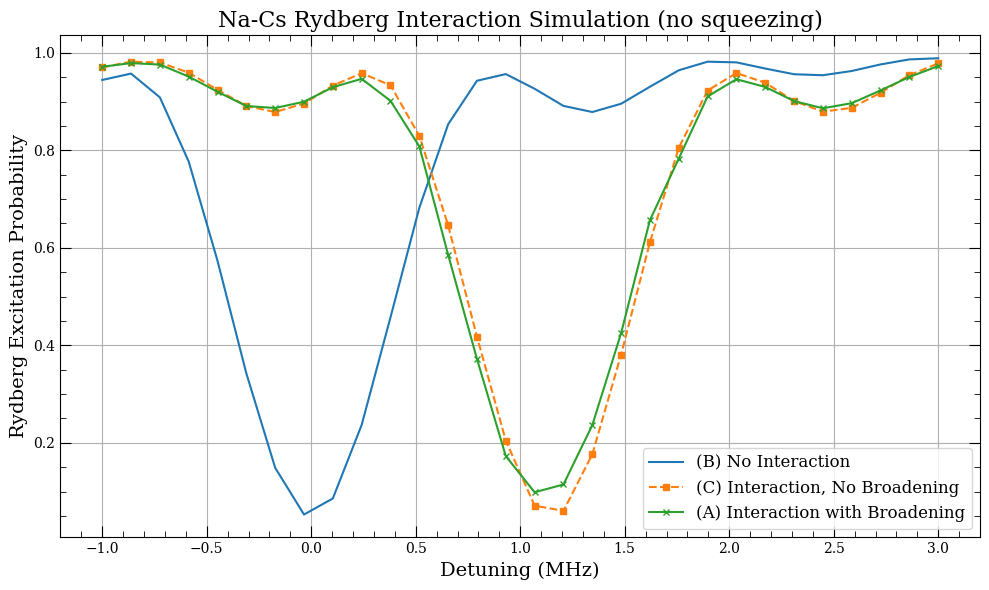

In [263]:
# ---------------------------------
# Main simulation
# ---------------------------------

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg_no_squeeze, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

# (B) without interaction
start_time = time.time()
d, P_no = scan_detuning(cfg_no_squeeze, c6_rad_um6=c6, interaction_on=False)
print(f"time for (B) without interaction: {time.time() - start_time:.1f} s")

# (C) without broadening
start_time = time.time()
d, P_no_broad = scan_detuning(ExperimentConfig(**{**cfg_no_squeeze.__dict__, "broadening": False}), c6_rad_um6=c6, interaction_on=True)
print(f"time for (C) without broadening: {time.time() - start_time:.1f} s")

# (A) with interaction
start_time = time.time()
d, P_int = scan_detuning(cfg_no_squeeze, c6_rad_um6=c6, interaction_on=True)
print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

print("Simulation done.")

# Plotting
plt.figure(figsize=(10,6))
plt.plot(d / 1e6, P_no, '-', label='(B) No Interaction', markersize=5)
plt.plot(d / 1e6, P_no_broad, 's--', label='(C) Interaction, No Broadening', markersize=5)
plt.plot(d / 1e6, P_int, 'x-', label='(A) Interaction with Broadening', markersize=5)
plt.xlabel('Detuning (MHz)', fontsize=14)
plt.ylabel('Rydberg Excitation Probability', fontsize=14)
plt.title('Na-Cs Rydberg Interaction Simulation (no squeezing)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

#### looking at position and momemntum distributions.

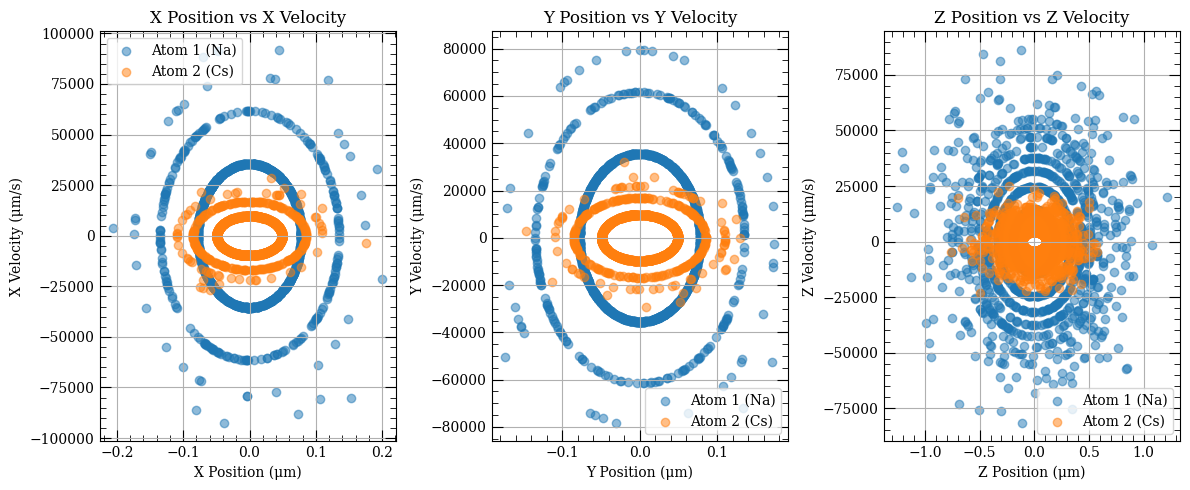

In [ ]:
# plot positions and velocities of both atoms for each axis (x, y, z)

x_pos_um_atom1 = np.array(cfg_no_squeeze.positions1_list)[:,0]
y_pos_um_atom1 = np.array(cfg_no_squeeze.positions1_list)[:,1]
z_pos_um_atom1 = np.array(cfg_no_squeeze.positions1_list)[:,2]
x_pos_um_atom2 = np.array(cfg_no_squeeze.positions2_list)[:,0]
y_pos_um_atom2 = np.array(cfg_no_squeeze.positions2_list)[:,1]
z_pos_um_atom2 = np.array(cfg_no_squeeze.positions2_list)[:,2]
vx_um_per_s_atom1 = np.array(cfg_no_squeeze.velocities1_list)[:,0]
vy_um_per_s_atom1 = np.array(cfg_no_squeeze.velocities1_list)[:,1]
vz_um_per_s_atom1 = np.array(cfg_no_squeeze.velocities1_list)[:,2]
vx_um_per_s_atom2 = np.array(cfg_no_squeeze.velocities2_list)[:,0]
vy_um_per_s_atom2 = np.array(cfg_no_squeeze.velocities2_list)[:,1]
vz_um_per_s_atom2 = np.array(cfg_no_squeeze.velocities2_list)[:,2]

# plot x position vs x velocity for both atoms
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(x_pos_um_atom1, vx_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(x_pos_um_atom2, vx_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('X Position (μm)')
plt.ylabel('X Velocity (μm/s)')
plt.title('X Position vs X Velocity')
plt.legend()
plt.grid()

# plot y position vs y velocity for both atoms
plt.subplot(1,3,2)
plt.scatter(y_pos_um_atom1, vy_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(y_pos_um_atom2, vy_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('Y Position (μm)')
plt.ylabel('Y Velocity (μm/s)')
plt.title('Y Position vs Y Velocity')
plt.legend()
plt.grid()

# plot z position vs z velocity for both atoms
plt.subplot(1,3,3)
plt.scatter(z_pos_um_atom1, vz_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(z_pos_um_atom2, vz_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('Z Position (μm)')
plt.ylabel('Z Velocity (μm/s)')
plt.title('Z Position vs Z Velocity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


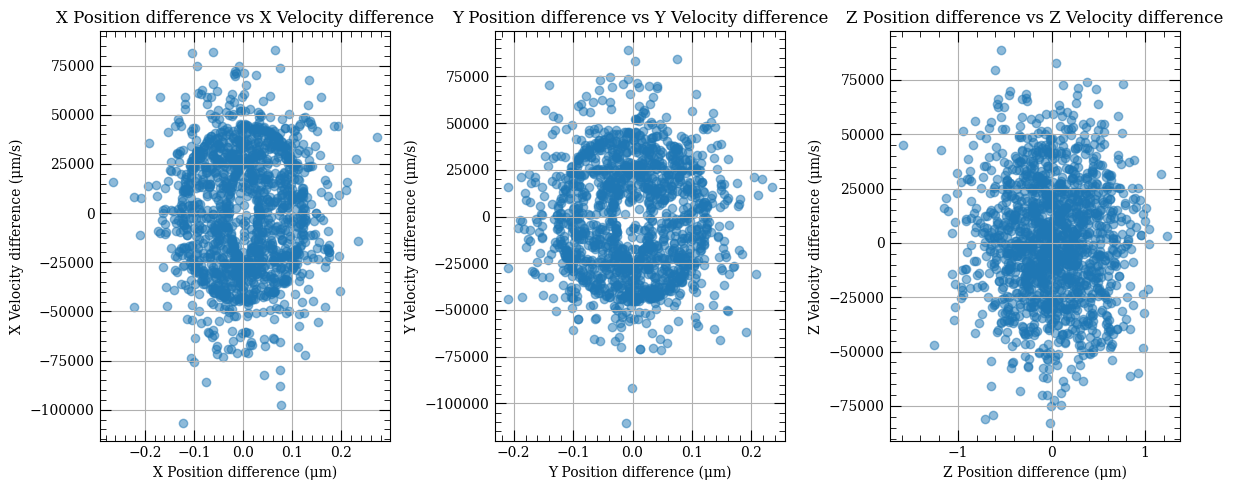

In [265]:
# plot cfg.positions_list vs cfg.velocities_list for (x,y,z)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
pos_x_no_squeeze = np.array(cfg_no_squeeze.positions_list)[:,0]
vel_x_no_squeeze = np.array(cfg_no_squeeze.velocities_list)[:,0]
# normalize pos_x and vel_x by their standard deviations
# pos_x = (pos_x - np.mean(pos_x)) / np.std(pos_x)
# vel_x = (vel_x - np.mean(vel_x)) / np.std(vel_x)
plt.scatter(pos_x_no_squeeze, vel_x_no_squeeze, label='', alpha=0.5)
plt.xlabel('X Position difference (μm)')
plt.ylabel('X Velocity difference (μm/s)')
plt.title('X Position difference vs X Velocity difference')
plt.grid()

plt.subplot(1,3,2)
pos_y_no_squeeze = np.array(cfg_no_squeeze.positions_list)[:,1]
vel_y_no_squeeze = np.array(cfg_no_squeeze.velocities_list)[:,1]
# normalize pos_y and vel_y by their standard deviations
# pos_y = (pos_y - np.mean(pos_y)) / np.std(pos_y)
# vel_y = (vel_y - np.mean(vel_y)) / np.std(vel_y)
plt.scatter(pos_y_no_squeeze, vel_y_no_squeeze, label='', alpha=0.5)
plt.xlabel('Y Position difference (μm)')
plt.ylabel('Y Velocity difference (μm/s)')
plt.title('Y Position difference vs Y Velocity difference')
plt.grid()

plt.subplot(1,3,3)
pos_z_no_squeeze = np.array(cfg_no_squeeze.positions_list)[:,2]
vel_z_no_squeeze = np.array(cfg_no_squeeze.velocities_list)[:,2]
# normalize pos_z and vel_z by their standard deviations
# pos_z = (pos_z - np.mean(pos_z)) / np.std(pos_z)
# vel_z = (vel_z - np.mean(vel_z)) / np.std(vel_z)
plt.scatter(pos_z_no_squeeze, vel_z_no_squeeze, label='', alpha=0.5)
plt.xlabel('Z Position difference (μm)')
plt.ylabel('Z Velocity difference (μm/s)')
plt.title('Z Position difference vs Z Velocity difference')
plt.grid()
plt.tight_layout()
plt.show()

### Implementing squeezing (only radial first)
From reading Sylnain's paper, we can do $x_{squeezed} = x / \beta$ and $p_{squeezed} = p * \beta$

#### first momentum squeeze (only radial)

In [266]:
# first checking without squeezing what is the position and momentum spread
pixel_to_um = 0.87 # imaging system calibration from Cs-Cs (Na-Cs gives ~ 0.87)
# pixel_to_um = 0.87
factor = 0.1
# Experiment configuration
cfg_mom_squeeze = ExperimentConfig(
    R_mean_um = 6.5 * pixel_to_um,  # mean interatomic distance in microns
    R_axis_um = (1.0, 0.0, 0.0),  # along x-axis
    OMEGA_atom1_Hz = 5.0e5,  # Na Rabi frequency (Hz)
    OMEGA_atom2_Hz = 0,  # Cs Rabi frequency (Hz) [no Cs drive] - just prepare Cs in Rydberg

    Delta_scan_Hz = np.linspace(-1, 3, 30) * 1e6, # detuning scan range (Hz)

    # Order: (x, y, z). (radial, radial, axial)
    # These are the *ground-state* trap temps of each tweezer. (uK)
    T_uK_atom1 = (2.0, 2.0, 2.0), # 2.0
    T_uK_atom2 = (1.0, 1.0, 1.0), # 1.0

    # These are the *ground-state* trap frequencies of each tweezer. (loading depth)
    omega_trap_atom1_Hz = (230e3, 230e3, 37e3), # using values from ryan 29Oct
    omega_trap_atom2_Hz = (100e3, 100e3, 20e3),

    load_factor = np.sqrt(0.1),  # % of trap depth after dropping

    T2_atom1_s = 5e-6, # coherence time for Na
    T2_atom2_s = 20e-6, # coherence time for Cs
    T1_use_ARC = True, # whether to use ARC lifetimes for T1

    broadening = True, # turn on or off broadening
    N_mc = 50,  # number of Monte Carlo samples per detuning
    N_steps = 20,  # number of time steps in evolution

    load_depth_T_atom1 = 350, # uK
    load_depth_T_atom2 = 100, # uK

    plot_displacements = False,  # whether to plot displacement histogram
    simulate_atom1_recapture=True,
    simulate_atom2_recapture=True,

    squeeze_factor = (factor, factor, 1.0),  # squeezing factor for each axis(1 = no squeezing)
)

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg_mom_squeeze, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s


Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s
Starting detuning scan...
  Point 2/30 - Elapsed: 0.0s, Est. remaining: 0.7s
  Point 4/30 - Elapsed: 0.2s, Est. remaining: 1.0s
  Point 6/30 - Elapsed: 0.3s, Est. remaining: 1.0s
  Point 8/30 - Elapsed: 0.3s, Est. remaining: 1.0s
  Point 10/30 - Elapsed: 0.4s, Est. remaining: 0.9s
  Point 12/30 - Elapsed: 0.5s, Est. remaining: 0.8s
  Point 14/30 - Elapsed: 0.6s, Est. remaining: 0.7s
  Point 16/30 - Elapsed: 0.7s, Est. remaining: 0.6s
  Point 18/30 - Elapsed: 0.8s, Est. remaining: 0.5s
  Point 20/30 - Elapsed: 0.9s, Est. remaining: 0.5s
  Point 22/30 - Elapsed: 1.0s, Est. remaining: 0.4s
  Point 24/30 - Elapsed: 1.1s, Est. remaining: 0.3s
  Point 26/30 - Elapsed: 1.2s, Est. remaining: 0.2s
  Point 28/30 - Elapsed: 1.3s, Est. remaining: 0.1s
  Point 30/30 - Elapsed: 1.5s, Est. remaining: 0.0s
time for (B) without interaction: 1.5 s
Sta

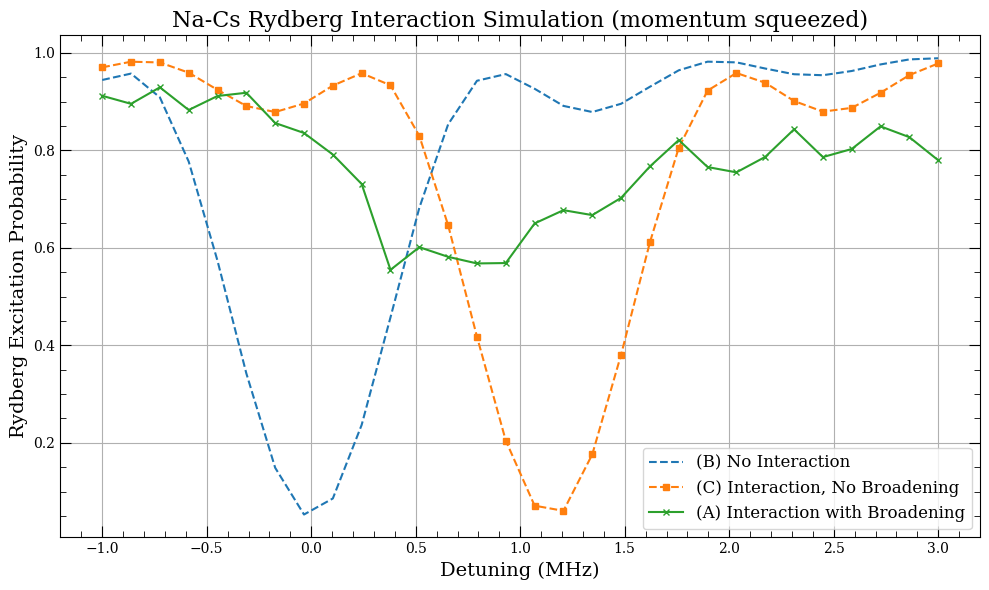

In [267]:
# ---------------------------------
# Main simulation
# ---------------------------------

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg_mom_squeeze, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

# (B) without interaction
start_time = time.time()
d, P_no = scan_detuning(cfg_mom_squeeze, c6_rad_um6=c6, interaction_on=False)
print(f"time for (B) without interaction: {time.time() - start_time:.1f} s")

# (C) without broadening
start_time = time.time()
d, P_no_broad = scan_detuning(ExperimentConfig(**{**cfg_mom_squeeze.__dict__, "broadening": False}), c6_rad_um6=c6, interaction_on=True)
print(f"time for (C) without broadening: {time.time() - start_time:.1f} s")

# (A) with interaction
start_time = time.time()
d, P_int_mom_squeeze = scan_detuning(cfg_mom_squeeze, c6_rad_um6=c6, interaction_on=True)
print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

print("Simulation done.")

# Plotting
plt.figure(figsize=(10,6))
plt.plot(d / 1e6, P_no, '--', label='(B) No Interaction', markersize=5)
plt.plot(d / 1e6, P_no_broad, 's--', label='(C) Interaction, No Broadening', markersize=5)
plt.plot(d / 1e6, P_int_mom_squeeze, 'x-', label='(A) Interaction with Broadening', markersize=5)
plt.xlabel('Detuning (MHz)', fontsize=14)
plt.ylabel('Rydberg Excitation Probability', fontsize=14)
plt.title('Na-Cs Rydberg Interaction Simulation (momentum squeezed)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

#### looking at position and momemntum distributions.

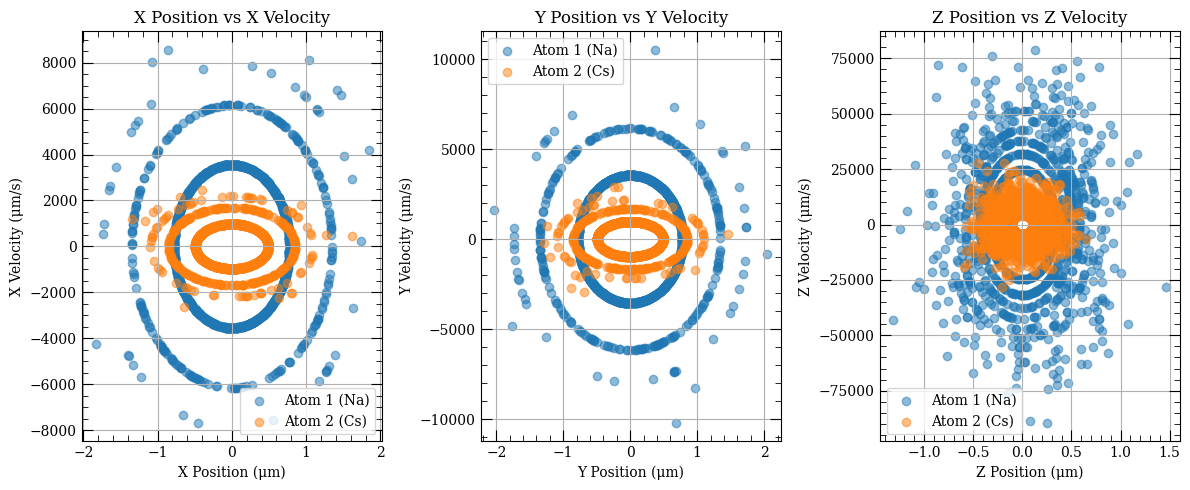

In [ ]:
# plot positions and velocities of both atoms for each axis (x, y, z)

x_pos_um_atom1 = np.array(cfg_mom_squeeze.positions1_list)[:,0]
y_pos_um_atom1 = np.array(cfg_mom_squeeze.positions1_list)[:,1]
z_pos_um_atom1 = np.array(cfg_mom_squeeze.positions1_list)[:,2]
x_pos_um_atom2 = np.array(cfg_mom_squeeze.positions2_list)[:,0]
y_pos_um_atom2 = np.array(cfg_mom_squeeze.positions2_list)[:,1]
z_pos_um_atom2 = np.array(cfg_mom_squeeze.positions2_list)[:,2]
vx_um_per_s_atom1 = np.array(cfg_mom_squeeze.velocities1_list)[:,0]
vy_um_per_s_atom1 = np.array(cfg_mom_squeeze.velocities1_list)[:,1]
vz_um_per_s_atom1 = np.array(cfg_mom_squeeze.velocities1_list)[:,2]
vx_um_per_s_atom2 = np.array(cfg_mom_squeeze.velocities2_list)[:,0]
vy_um_per_s_atom2 = np.array(cfg_mom_squeeze.velocities2_list)[:,1]
vz_um_per_s_atom2 = np.array(cfg_mom_squeeze.velocities2_list)[:,2]

# plot x position vs x velocity for both atoms
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(x_pos_um_atom1, vx_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(x_pos_um_atom2, vx_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('X Position (μm)')
plt.ylabel('X Velocity (μm/s)')
plt.title('X Position vs X Velocity')
plt.legend()
plt.grid()

# plot y position vs y velocity for both atoms
plt.subplot(1,3,2)
plt.scatter(y_pos_um_atom1, vy_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(y_pos_um_atom2, vy_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('Y Position (μm)')
plt.ylabel('Y Velocity (μm/s)')
plt.title('Y Position vs Y Velocity')
plt.legend()
plt.grid()

# plot z position vs z velocity for both atoms
plt.subplot(1,3,3)
plt.scatter(z_pos_um_atom1, vz_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(z_pos_um_atom2, vz_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('Z Position (μm)')
plt.ylabel('Z Velocity (μm/s)')
plt.title('Z Position vs Z Velocity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


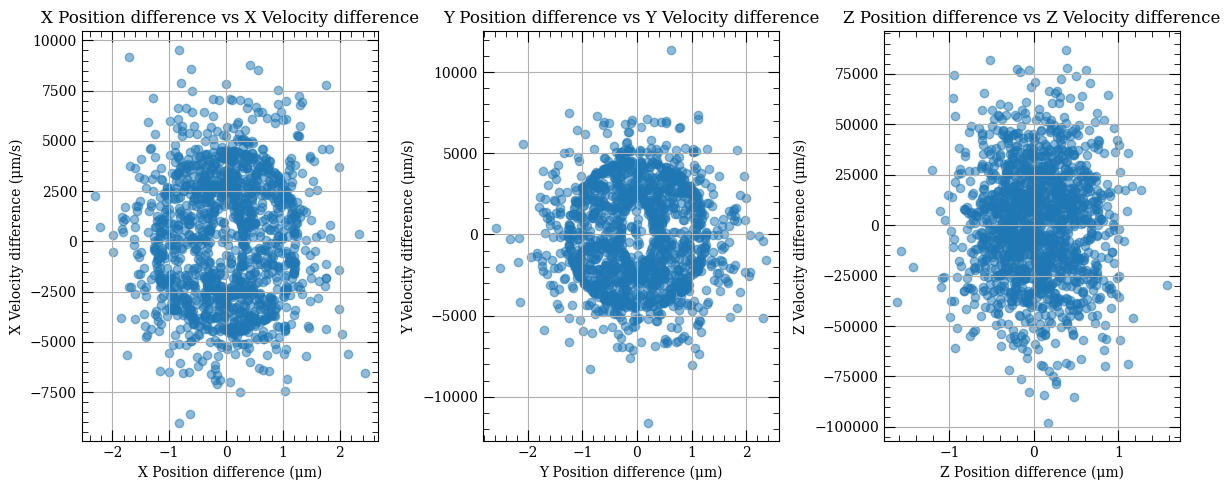

In [269]:
# plot cfg.positions_list vs cfg.velocities_list for (x,y,z)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
pos_x_mom_squeeze = np.array(cfg_mom_squeeze.positions_list)[:,0]
vel_x_mom_squeeze = np.array(cfg_mom_squeeze.velocities_list)[:,0]
# normalize pos_x and vel_x by their standard deviations
# pos_x = (pos_x - np.mean(pos_x)) / np.std(pos_x)
# vel_x = (vel_x - np.mean(vel_x)) / np.std(vel_x)
plt.scatter(pos_x_mom_squeeze, vel_x_mom_squeeze, label='', alpha=0.5)
plt.xlabel('X Position difference (μm)')
plt.ylabel('X Velocity difference (μm/s)')
plt.title('X Position difference vs X Velocity difference')
plt.grid()

plt.subplot(1,3,2)
pos_y_mom_squeeze = np.array(cfg_mom_squeeze.positions_list)[:,1]
vel_y_mom_squeeze = np.array(cfg_mom_squeeze.velocities_list)[:,1]
# normalize pos_y and vel_y by their standard deviations
# pos_y = (pos_y - np.mean(pos_y)) / np.std(pos_y)
# vel_y = (vel_y - np.mean(vel_y)) / np.std(vel_y)
plt.scatter(pos_y_mom_squeeze, vel_y_mom_squeeze, label='', alpha=0.5)
plt.xlabel('Y Position difference (μm)')
plt.ylabel('Y Velocity difference (μm/s)')
plt.title('Y Position difference vs Y Velocity difference')
plt.grid()

plt.subplot(1,3,3)
pos_z_mom_squeeze = np.array(cfg_mom_squeeze.positions_list)[:,2]
vel_z_mom_squeeze = np.array(cfg_mom_squeeze.velocities_list)[:,2]
# normalize pos_z and vel_z by their standard deviations
# pos_z = (pos_z - np.mean(pos_z)) / np.std(pos_z)
# vel_z = (vel_z - np.mean(vel_z)) / np.std(vel_z)
plt.scatter(pos_z_mom_squeeze, vel_z_mom_squeeze, label='', alpha=0.5)
plt.xlabel('Z Position difference (μm)')
plt.ylabel('Z Velocity difference (μm/s)')
plt.title('Z Position difference vs Z Velocity difference')
plt.grid()
plt.tight_layout()
plt.show()

#### now position squeeze (only radial)

In [270]:
# first checking without squeezing what is the position and momentum spread
pixel_to_um = 0.87 # imaging system calibration from Cs-Cs (Na-Cs gives ~ 0.87)
# pixel_to_um = 0.87
factor = 1/0.1
# Experiment configuration
cfg_pos_squeeze = ExperimentConfig(
    R_mean_um = 6.5 * pixel_to_um,  # mean interatomic distance in microns
    R_axis_um = (1.0, 0.0, 0.0),  # along x-axis
    OMEGA_atom1_Hz = 5.0e5,  # Na Rabi frequency (Hz)
    OMEGA_atom2_Hz = 0,  # Cs Rabi frequency (Hz) [no Cs drive] - just prepare Cs in Rydberg

    Delta_scan_Hz = np.linspace(-1, 3, 30) * 1e6, # detuning scan range (Hz)

    # Order: (x, y, z). (radial, radial, axial)
    # These are the *ground-state* trap temps of each tweezer. (uK)
    T_uK_atom1 = (2.0, 2.0, 2.0), # 2.0
    T_uK_atom2 = (1.0, 1.0, 1.0), # 1.0

    # These are the *ground-state* trap frequencies of each tweezer. (loading depth)
    omega_trap_atom1_Hz = (230e3, 230e3, 37e3), # using values from ryan 29Oct
    omega_trap_atom2_Hz = (100e3, 100e3, 20e3),

    load_factor = np.sqrt(0.1),  # % of trap depth after dropping

    T2_atom1_s = 5e-6, # coherence time for Na
    T2_atom2_s = 20e-6, # coherence time for Cs
    T1_use_ARC = True, # whether to use ARC lifetimes for T1

    broadening = True, # turn on or off broadening
    N_mc = 50,  # number of Monte Carlo samples per detuning
    N_steps = 20,  # number of time steps in evolution

    load_depth_T_atom1 = 350, # uK
    load_depth_T_atom2 = 100, # uK

    plot_displacements = False,  # whether to plot displacement histogram
    simulate_atom1_recapture=True,
    simulate_atom2_recapture=True,

    squeeze_factor = (factor, factor, 1.0),  # squeezing factor for each axis(1 = no squeezing)
)

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg_pos_squeeze, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s


Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s
Starting detuning scan...
  Point 2/30 - Elapsed: 0.0s, Est. remaining: 0.7s
  Point 4/30 - Elapsed: 0.1s, Est. remaining: 0.9s
  Point 6/30 - Elapsed: 0.2s, Est. remaining: 1.0s
  Point 8/30 - Elapsed: 0.3s, Est. remaining: 0.9s
  Point 10/30 - Elapsed: 0.4s, Est. remaining: 0.9s
  Point 12/30 - Elapsed: 0.5s, Est. remaining: 0.8s
  Point 14/30 - Elapsed: 0.6s, Est. remaining: 0.7s
  Point 16/30 - Elapsed: 0.7s, Est. remaining: 0.6s
  Point 18/30 - Elapsed: 0.8s, Est. remaining: 0.5s
  Point 20/30 - Elapsed: 0.9s, Est. remaining: 0.5s
  Point 22/30 - Elapsed: 1.0s, Est. remaining: 0.4s
  Point 24/30 - Elapsed: 1.1s, Est. remaining: 0.3s
  Point 26/30 - Elapsed: 1.2s, Est. remaining: 0.2s
  Point 28/30 - Elapsed: 1.3s, Est. remaining: 0.1s
  Point 30/30 - Elapsed: 1.4s, Est. remaining: 0.0s
time for (B) without interaction: 1.5 s
Sta

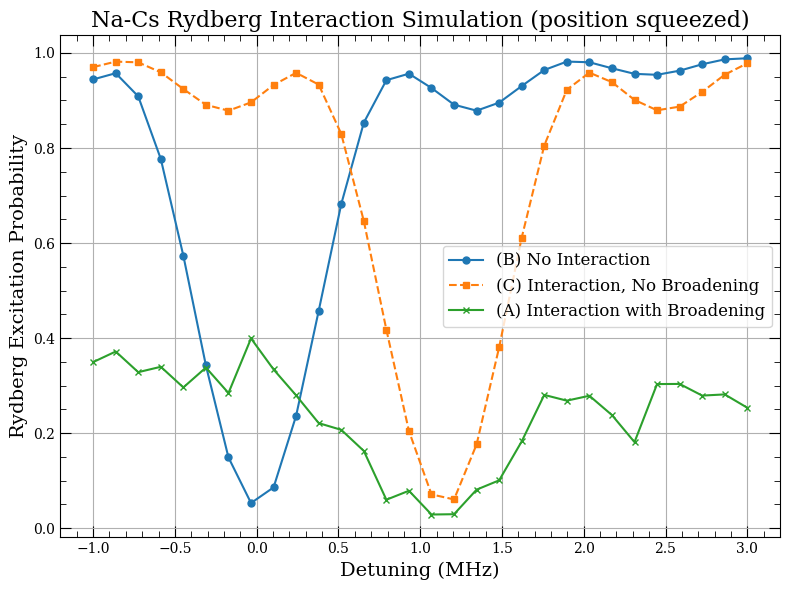

In [271]:
# ---------------------------------
# Main simulation
# ---------------------------------

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg_pos_squeeze, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

# (B) without interaction
start_time = time.time()
d, P_no = scan_detuning(cfg_pos_squeeze, c6_rad_um6=c6, interaction_on=False)
print(f"time for (B) without interaction: {time.time() - start_time:.1f} s")

# (C) without broadening
start_time = time.time()
d, P_no_broad = scan_detuning(ExperimentConfig(**{**cfg_pos_squeeze.__dict__, "broadening": False}), c6_rad_um6=c6, interaction_on=True)
print(f"time for (C) without broadening: {time.time() - start_time:.1f} s")

# (A) with interaction
start_time = time.time()
d, P_int_pos_squeeze = scan_detuning(cfg_pos_squeeze, c6_rad_um6=c6, interaction_on=True)
print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

print("Simulation done.")

# Plotting
plt.figure(figsize=(8,6))
plt.plot(d / 1e6, P_no, 'o-', label='(B) No Interaction', markersize=5)
plt.plot(d / 1e6, P_no_broad, 's--', label='(C) Interaction, No Broadening', markersize=5)
plt.plot(d / 1e6, P_int_pos_squeeze, 'x-', label='(A) Interaction with Broadening', markersize=5)
plt.xlabel('Detuning (MHz)', fontsize=14)
plt.ylabel('Rydberg Excitation Probability', fontsize=14)
plt.title('Na-Cs Rydberg Interaction Simulation (position squeezed)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

#### looking at position and momemntum distributions.

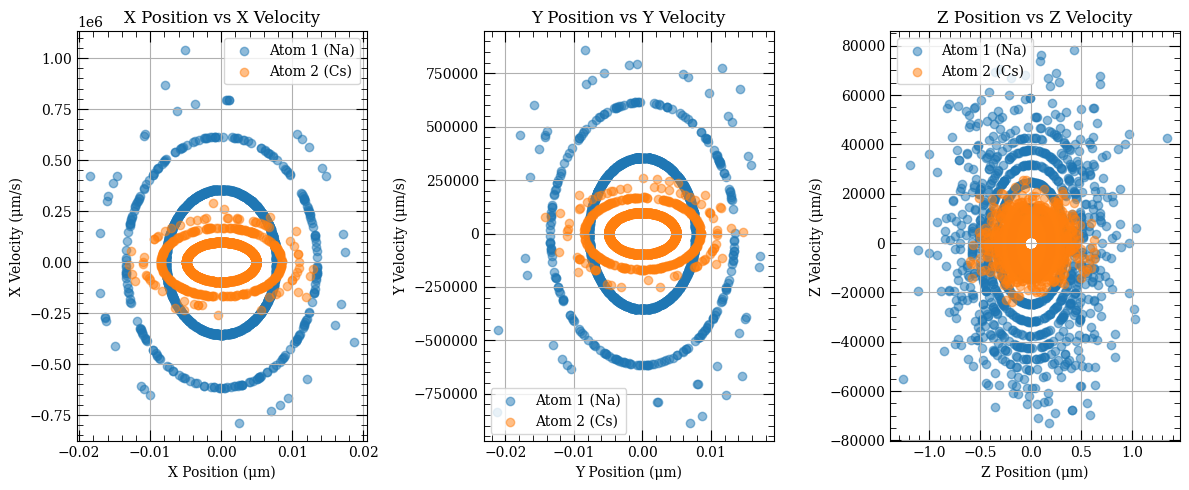

In [272]:
# plot positions and velocities of both atoms for each axis (x, y, z)

x_pos_um_atom1 = np.array(cfg_pos_squeeze.positions1_list)[:,0]
y_pos_um_atom1 = np.array(cfg_pos_squeeze.positions1_list)[:,1]
z_pos_um_atom1 = np.array(cfg_pos_squeeze.positions1_list)[:,2]
x_pos_um_atom2 = np.array(cfg_pos_squeeze.positions2_list)[:,0]
y_pos_um_atom2 = np.array(cfg_pos_squeeze.positions2_list)[:,1]
z_pos_um_atom2 = np.array(cfg_pos_squeeze.positions2_list)[:,2]
vx_um_per_s_atom1 = np.array(cfg_pos_squeeze.velocities1_list)[:,0]
vy_um_per_s_atom1 = np.array(cfg_pos_squeeze.velocities1_list)[:,1]
vz_um_per_s_atom1 = np.array(cfg_pos_squeeze.velocities1_list)[:,2]
vx_um_per_s_atom2 = np.array(cfg_pos_squeeze.velocities2_list)[:,0]
vy_um_per_s_atom2 = np.array(cfg_pos_squeeze.velocities2_list)[:,1]
vz_um_per_s_atom2 = np.array(cfg_pos_squeeze.velocities2_list)[:,2]

# # normalize the positions and velocities using min-max normalization for better visualization
# x_pos_um_atom1 = (x_pos_um_atom1 - np.min(x_pos_um_atom1)) / (np.max(x_pos_um_atom1) - np.min(x_pos_um_atom1))
# y_pos_um_atom1 = (y_pos_um_atom1 - np.min(y_pos_um_atom1)) / (np.max(y_pos_um_atom1) - np.min(y_pos_um_atom1))
# z_pos_um_atom1 = (z_pos_um_atom1 - np.min(z_pos_um_atom1)) / (np.max(z_pos_um_atom1) - np.min(z_pos_um_atom1))
# x_pos_um_atom2 = (x_pos_um_atom2 - np.min(x_pos_um_atom2)) / (np.max(x_pos_um_atom2) - np.min(x_pos_um_atom2))
# y_pos_um_atom2 = (y_pos_um_atom2 - np.min(y_pos_um_atom2)) / (np.max(y_pos_um_atom2) - np.min(y_pos_um_atom2))
# z_pos_um_atom2 = (z_pos_um_atom2 - np.min(z_pos_um_atom2)) / (np.max(z_pos_um_atom2) - np.min(z_pos_um_atom2))
# vx_um_per_s_atom1 = (vx_um_per_s_atom1 - np.min(vx_um_per_s_atom1)) / (np.max(vx_um_per_s_atom1) - np.min(vx_um_per_s_atom1))
# vy_um_per_s_atom1 = (vy_um_per_s_atom1 - np.min(vy_um_per_s_atom1)) / (np.max(vy_um_per_s_atom1) - np.min(vy_um_per_s_atom1))
# vz_um_per_s_atom1 = (vz_um_per_s_atom1 - np.min(vz_um_per_s_atom1)) / (np.max(vz_um_per_s_atom1) - np.min(vz_um_per_s_atom1))
# vx_um_per_s_atom2 = (vx_um_per_s_atom2 - np.min(vx_um_per_s_atom2)) / (np.max(vx_um_per_s_atom2) - np.min(vx_um_per_s_atom2))
# vy_um_per_s_atom2 = (vy_um_per_s_atom2 - np.min(vy_um_per_s_atom2)) / (np.max(vy_um_per_s_atom2) - np.min(vy_um_per_s_atom2))
# vz_um_per_s_atom2 = (vz_um_per_s_atom2 - np.min(vz_um_per_s_atom2)) / (np.max(vz_um_per_s_atom2) - np.min(vz_um_per_s_atom2))



# plot x position vs x velocity for both atoms
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(x_pos_um_atom1, vx_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(x_pos_um_atom2, vx_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('X Position (μm)')
plt.ylabel('X Velocity (μm/s)')
plt.title('X Position vs X Velocity')
plt.legend()
plt.grid()

# plot y position vs y velocity for both atoms
plt.subplot(1,3,2)
plt.scatter(y_pos_um_atom1, vy_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(y_pos_um_atom2, vy_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('Y Position (μm)')
plt.ylabel('Y Velocity (μm/s)')
plt.title('Y Position vs Y Velocity')
plt.legend()
plt.grid()

# plot z position vs z velocity for both atoms
plt.subplot(1,3,3)
plt.scatter(z_pos_um_atom1, vz_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(z_pos_um_atom2, vz_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('Z Position (μm)')
plt.ylabel('Z Velocity (μm/s)')
plt.title('Z Position vs Z Velocity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


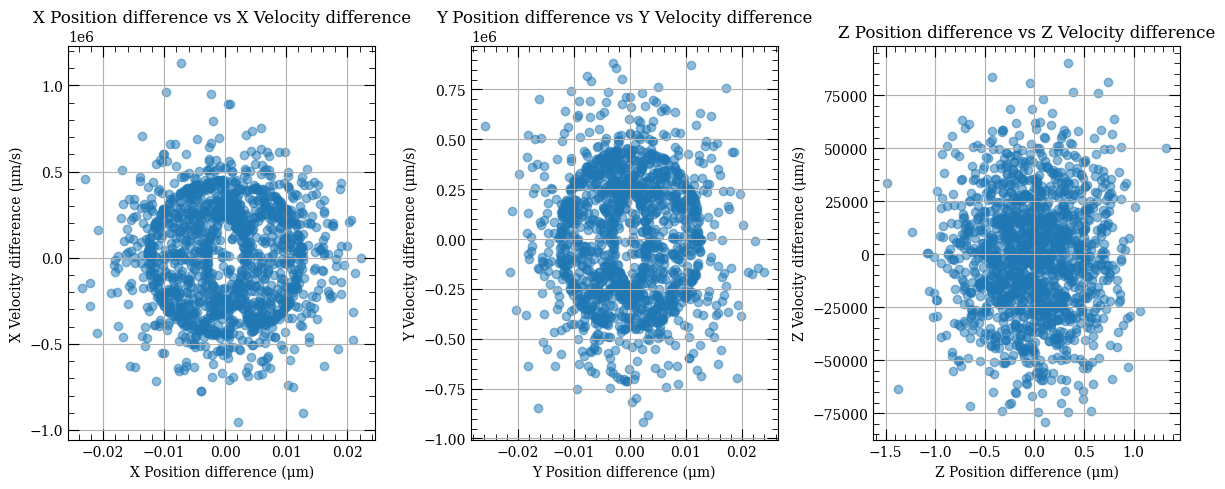

In [273]:
# plot cfg.positions_list vs cfg.velocities_list for (x,y,z)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
pos_x_pos_squeeze = np.array(cfg_pos_squeeze.positions_list)[:,0]
vel_x_pos_squeeze = np.array(cfg_pos_squeeze.velocities_list)[:,0]
# normalize pos_x and vel_x by their standard deviations
# pos_x = (pos_x - np.mean(pos_x)) / np.std(pos_x)
# vel_x = (vel_x - np.mean(vel_x)) / np.std(vel_x)
plt.scatter(pos_x_pos_squeeze, vel_x_pos_squeeze, label='', alpha=0.5)
plt.xlabel('X Position difference (μm)')
plt.ylabel('X Velocity difference (μm/s)')
plt.title('X Position difference vs X Velocity difference')
plt.grid()

plt.subplot(1,3,2)
pos_y_pos_squeeze = np.array(cfg_pos_squeeze.positions_list)[:,1]
vel_y_pos_squeeze = np.array(cfg_pos_squeeze.velocities_list)[:,1]
# normalize pos_y and vel_y by their standard deviations
# pos_y = (pos_y - np.mean(pos_y)) / np.std(pos_y)
# vel_y = (vel_y - np.mean(vel_y)) / np.std(vel_y)
plt.scatter(pos_y_pos_squeeze, vel_y_pos_squeeze, label='', alpha=0.5)
plt.xlabel('Y Position difference (μm)')
plt.ylabel('Y Velocity difference (μm/s)')
plt.title('Y Position difference vs Y Velocity difference')
plt.grid()

plt.subplot(1,3,3)
pos_z_pos_squeeze = np.array(cfg_pos_squeeze.positions_list)[:,2]
vel_z_pos_squeeze = np.array(cfg_pos_squeeze.velocities_list)[:,2]
# normalize pos_z and vel_z by their standard deviations
# pos_z = (pos_z - np.mean(pos_z)) / np.std(pos_z)
# vel_z = (vel_z - np.mean(vel_z)) / np.std(vel_z)
plt.scatter(pos_z_pos_squeeze, vel_z_pos_squeeze, label='', alpha=0.5)
plt.xlabel('Z Position difference (μm)')
plt.ylabel('Z Velocity difference (μm/s)')
plt.title('Z Position difference vs Z Velocity difference')
plt.grid()
plt.tight_layout()
plt.show()

### Plotting all of them for comparison

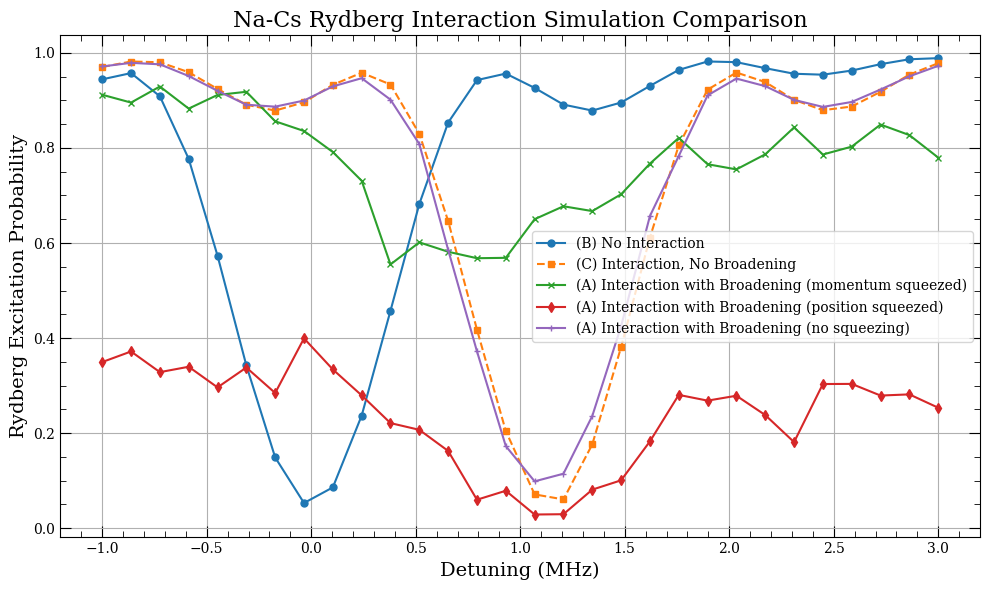

In [274]:
# plot no squeezing, momentum squeezing, and position squeezing all together for comparison
plt.figure(figsize=(10,6))
plt.plot(d / 1e6, P_no, 'o-', label='(B) No Interaction', markersize=5)
plt.plot(d / 1e6, P_no_broad, 's--', label='(C) Interaction, No Broadening', markersize=5)
plt.plot(d / 1e6, P_int_mom_squeeze, 'x-', label='(A) Interaction with Broadening (momentum squeezed)', markersize=5)
plt.plot(d / 1e6, P_int_pos_squeeze, 'd-', label='(A) Interaction with Broadening (position squeezed)', markersize=5)
plt.plot(d / 1e6, P_int, '+-', label='(A) Interaction with Broadening (no squeezing)', markersize=5)
plt.xlabel('Detuning (MHz)', fontsize=14)
plt.ylabel('Rydberg Excitation Probability', fontsize=14)
plt.title('Na-Cs Rydberg Interaction Simulation Comparison', fontsize=16)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

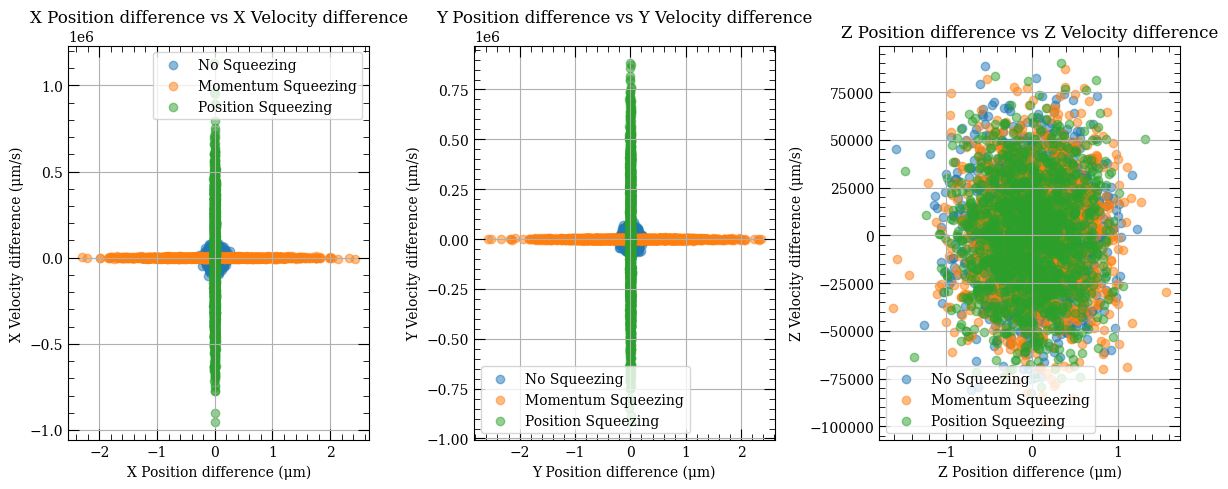

In [275]:
# plot pos vs vel for no squeezing, momentum squeezing, and position squeezing for x axis only
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(pos_x_no_squeeze, vel_x_no_squeeze, label='No Squeezing', alpha=0.5)
plt.scatter(pos_x_mom_squeeze, vel_x_mom_squeeze, label='Momentum Squeezing', alpha=0.5)
plt.scatter(pos_x_pos_squeeze, vel_x_pos_squeeze, label='Position Squeezing', alpha=0.5)
plt.xlabel('X Position difference (μm)')
plt.ylabel('X Velocity difference (μm/s)')
plt.title('X Position difference vs X Velocity difference')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.scatter(pos_y_no_squeeze, vel_y_no_squeeze, label='No Squeezing', alpha=0.5)
plt.scatter(pos_y_mom_squeeze, vel_y_mom_squeeze, label='Momentum Squeezing', alpha=0.5)
plt.scatter(pos_y_pos_squeeze, vel_y_pos_squeeze, label='Position Squeezing', alpha=0.5)
plt.xlabel('Y Position difference (μm)')
plt.ylabel('Y Velocity difference (μm/s)')
plt.title('Y Position difference vs Y Velocity difference')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.scatter(pos_z_no_squeeze, vel_z_no_squeeze, label='No Squeezing', alpha=0.5)
plt.scatter(pos_z_mom_squeeze, vel_z_mom_squeeze, label='Momentum Squeezing', alpha=0.5)
plt.scatter(pos_z_pos_squeeze, vel_z_pos_squeeze, label='Position Squeezing', alpha=0.5)
plt.xlabel('Z Position difference (μm)')
plt.ylabel('Z Velocity difference (μm/s)')
plt.title('Z Position difference vs Z Velocity difference')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Release recapture comparison.

#### no squeezing

Starting detuning scan...
time for (A) with interaction: 0.2 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction

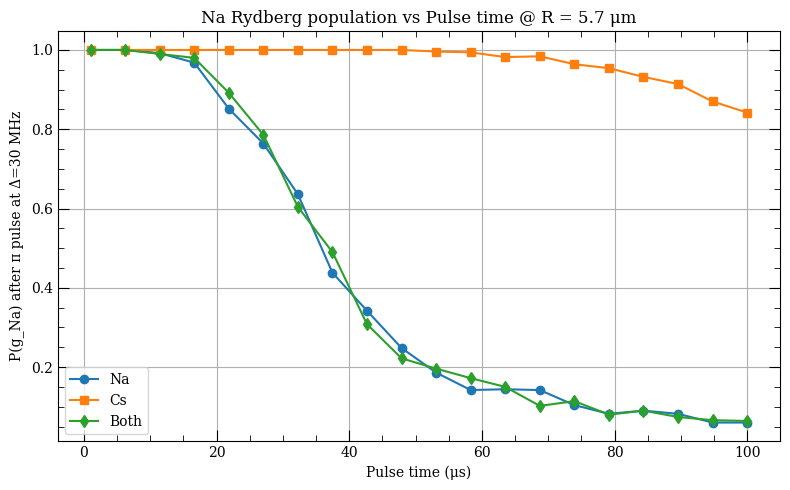

In [276]:
cfg_no_squeeze.hamiltonian_on = False
cfg_no_squeeze.Delta_scan_Hz = np.array([1e6]), # single detuning value (Hz)
cfg_no_squeeze.OMEGA_atom1_Hz = 0  # Na Rabi frequency (Hz)
cfg_no_squeeze.OMEGA_atom2_Hz = 0  # Cs Rabi frequency (Hz)
cfg_no_squeeze.N_mc = 500
cfg_no_squeeze.N_steps = 100

# sweep over pulse times (Rabi frequencies)
pulse_times_us = np.linspace(1, 100, 20)  # in microseconds
colors = plt.cm.viridis(np.linspace(0, 1, len(pulse_times_us)))

# first only Na release curve vs pulse time (no squeezing)
cfg_no_squeeze.simulate_atom1_recapture = True
cfg_no_squeeze.simulate_atom2_recapture = False

# rabi_freqs_Hz = (np.pi / (2 * (pulse_times_us * 1e-6)))  # in Hz
pop_array_Na_no_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_no_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()
    
    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_no_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Na_no_squeeze.append(P_int[0])  # only one detuning point

# now for Cs release curve vs pulse time (no squeezing)
cfg_no_squeeze.simulate_atom1_recapture = False
cfg_no_squeeze.simulate_atom2_recapture = True

pop_array_Cs_no_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_no_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_no_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Cs_no_squeeze.append(P_int[0])  # only one detuning point

# now both atoms recapture vs pulse time (no squeezing)
cfg_no_squeeze.simulate_atom1_recapture = True
cfg_no_squeeze.simulate_atom2_recapture = True
pop_array_both_no_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_no_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_no_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_both_no_squeeze.append(P_int[0])  # only one detuning point

# plot pulse time vs population
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us, np.array(pop_array_Na_no_squeeze), "o-", label="Na")
plt.plot(pulse_times_us, np.array(pop_array_Cs_no_squeeze), "s-", label="Cs")
plt.plot(pulse_times_us, np.array(pop_array_both_no_squeeze), "d-", label="Both")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g_Na) after π pulse at Δ=30 MHz")
plt.title(f"Na Rydberg population vs Pulse time @ R = {cfg_no_squeeze.R_mean_um:.1f} μm")
# set x-axis to log scale
# plt.xscale("log")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### momentum squeezed.

Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.2 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.2 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.2 s
Starting detuning scan...
time for (A) with interaction: 0.2 s
Starting detuning scan...
time for (A) with interaction

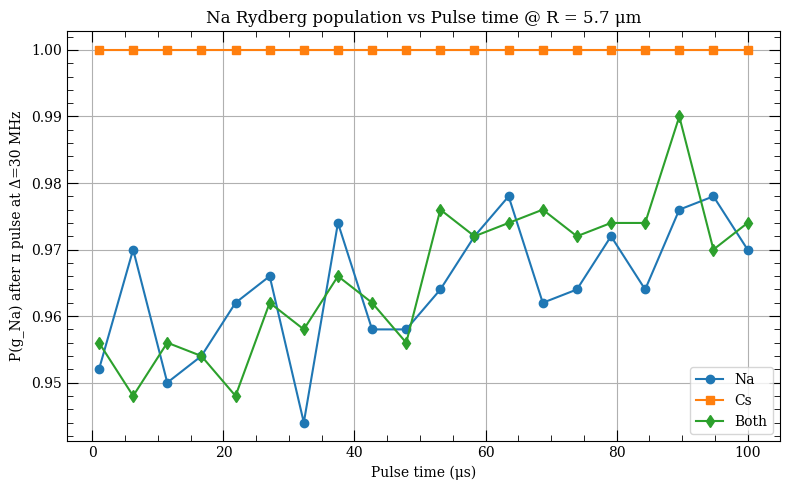

In [277]:
cfg_mom_squeeze.hamiltonian_on = False
cfg_mom_squeeze.Delta_scan_Hz = np.array([1e6]), # single detuning value (Hz)
cfg_mom_squeeze.OMEGA_atom1_Hz = 0  # Na Rabi frequency (Hz)
cfg_mom_squeeze.OMEGA_atom2_Hz = 0  # Cs Rabi frequency (Hz)
cfg_mom_squeeze.N_mc = 500
cfg_mom_squeeze.N_steps = 100

# sweep over pulse times (Rabi frequencies)
pulse_times_us = np.linspace(1, 100, 20)  # in microseconds
colors = plt.cm.viridis(np.linspace(0, 1, len(pulse_times_us)))

# first only Na release curve vs pulse time (no squeezing)
cfg_mom_squeeze.simulate_atom1_recapture = True
cfg_mom_squeeze.simulate_atom2_recapture = False

# rabi_freqs_Hz = (np.pi / (2 * (pulse_times_us * 1e-6)))  # in Hz
pop_array_Na_mom_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_mom_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()
    
    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_mom_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Na_mom_squeeze.append(P_int[0])  # only one detuning point

# now for Cs release curve vs pulse time (no squeezing)
cfg_mom_squeeze.simulate_atom1_recapture = False
cfg_mom_squeeze.simulate_atom2_recapture = True

pop_array_Cs_mom_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_mom_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_mom_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Cs_mom_squeeze.append(P_int[0])  # only one detuning point

# now both atoms recapture vs pulse time (no squeezing)
cfg_mom_squeeze.simulate_atom1_recapture = True
cfg_mom_squeeze.simulate_atom2_recapture = True
pop_array_both_mom_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_mom_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_mom_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_both_mom_squeeze.append(P_int[0])  # only one detuning point

# plot pulse time vs population
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us, np.array(pop_array_Na_mom_squeeze), "o-", label="Na")
plt.plot(pulse_times_us, np.array(pop_array_Cs_mom_squeeze), "s-", label="Cs")
plt.plot(pulse_times_us, np.array(pop_array_both_mom_squeeze), "d-", label="Both")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g_Na) after π pulse at Δ=30 MHz")
plt.title(f"Na Rydberg population vs Pulse time @ R = {cfg_no_squeeze.R_mean_um:.1f} μm")
# set x-axis to log scale
# plt.xscale("log")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Position squeezed.

Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction

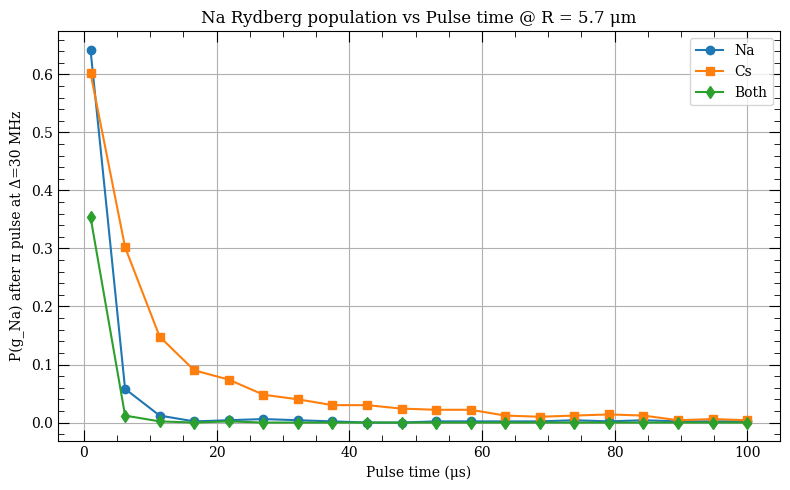

In [278]:
cfg_pos_squeeze.hamiltonian_on = False
cfg_pos_squeeze.Delta_scan_Hz = np.array([1e6]), # single detuning value (Hz)
cfg_pos_squeeze.OMEGA_atom1_Hz = 0  # Na Rabi frequency (Hz)
cfg_pos_squeeze.OMEGA_atom2_Hz = 0  # Cs Rabi frequency (Hz)
cfg_pos_squeeze.N_mc = 500
cfg_pos_squeeze.N_steps = 100

# sweep over pulse times (Rabi frequencies)
pulse_times_us = np.linspace(1, 100, 20)  # in microseconds
colors = plt.cm.viridis(np.linspace(0, 1, len(pulse_times_us)))

# first only Na release curve vs pulse time (no squeezing)
cfg_pos_squeeze.simulate_atom1_recapture = True
cfg_pos_squeeze.simulate_atom2_recapture = False

# rabi_freqs_Hz = (np.pi / (2 * (pulse_times_us * 1e-6)))  # in Hz
pop_array_Na_pos_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_pos_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()
    
    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_pos_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Na_pos_squeeze.append(P_int[0])  # only one detuning point

# now for Cs release curve vs pulse time (no squeezing)
cfg_pos_squeeze.simulate_atom1_recapture = False
cfg_pos_squeeze.simulate_atom2_recapture = True

pop_array_Cs_pos_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_pos_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_pos_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Cs_pos_squeeze.append(P_int[0])  # only one detuning point

# now both atoms recapture vs pulse time (no squeezing)
cfg_pos_squeeze.simulate_atom1_recapture = True
cfg_pos_squeeze.simulate_atom2_recapture = True
pop_array_both_pos_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_pos_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_pos_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_both_pos_squeeze.append(P_int[0])  # only one detuning point

# plot pulse time vs population
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us, np.array(pop_array_Na_pos_squeeze), "o-", label="Na")
plt.plot(pulse_times_us, np.array(pop_array_Cs_pos_squeeze), "s-", label="Cs")
plt.plot(pulse_times_us, np.array(pop_array_both_pos_squeeze), "d-", label="Both")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g_Na) after π pulse at Δ=30 MHz")
plt.title(f"Na Rydberg population vs Pulse time @ R = {cfg_no_squeeze.R_mean_um:.1f} μm")
# set x-axis to log scale
# plt.xscale("log")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### comparison plot

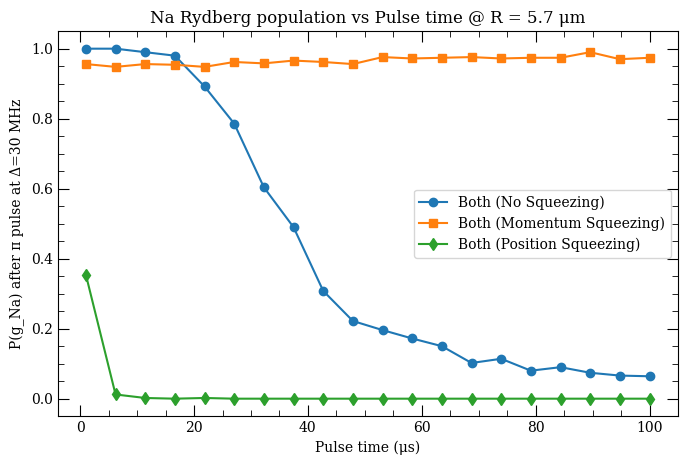

In [279]:
# plot a comparison of all three release curves for Na, Cs, and both atoms
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us, np.array(pop_array_both_no_squeeze), "o-", label="Both (No Squeezing)")
plt.plot(pulse_times_us, np.array(pop_array_both_mom_squeeze), "s-", label="Both (Momentum Squeezing)")
plt.plot(pulse_times_us, np.array(pop_array_both_pos_squeeze), "d-", label="Both (Position Squeezing)")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g_Na) after π pulse at Δ=30 MHz")
plt.title(f"Na Rydberg population vs Pulse time @ R = {cfg_no_squeeze.R_mean_um:.1f} μm")
plt.legend()
plt.show()

### Implementing squeezing (only axial now)
From reading Sylnain's paper, we can do $x_{squeezed} = x / \beta$ and $p_{squeezed} = p * \beta$

#### first momentum squeeze (only radial)

In [235]:
# first checking without squeezing what is the position and momentum spread
pixel_to_um = 0.87 # imaging system calibration from Cs-Cs (Na-Cs gives ~ 0.87)
# pixel_to_um = 0.87
factor = 0.25
# Experiment configuration
cfg_mom_squeeze = ExperimentConfig(
    R_mean_um = 6.5 * pixel_to_um,  # mean interatomic distance in microns
    R_axis_um = (1.0, 0.0, 0.0),  # along x-axis
    OMEGA_atom1_Hz = 5.0e5,  # Na Rabi frequency (Hz)
    OMEGA_atom2_Hz = 0,  # Cs Rabi frequency (Hz) [no Cs drive] - just prepare Cs in Rydberg

    Delta_scan_Hz = np.linspace(-1, 3, 30) * 1e6, # detuning scan range (Hz)

    # Order: (x, y, z). (radial, radial, axial)
    # These are the *ground-state* trap temps of each tweezer. (uK)
    T_uK_atom1 = (2.0, 2.0, 2.0), # 2.0
    T_uK_atom2 = (1.0, 1.0, 1.0), # 1.0

    # These are the *ground-state* trap frequencies of each tweezer. (loading depth)
    omega_trap_atom1_Hz = (230e3, 230e3, 37e3), # using values from ryan 29Oct
    omega_trap_atom2_Hz = (100e3, 100e3, 20e3),

    load_factor = np.sqrt(0.1),  # % of trap depth after dropping

    T2_atom1_s = 5e-6, # coherence time for Na
    T2_atom2_s = 20e-6, # coherence time for Cs
    T1_use_ARC = True, # whether to use ARC lifetimes for T1

    broadening = True, # turn on or off broadening
    N_mc = 50,  # number of Monte Carlo samples per detuning
    N_steps = 20,  # number of time steps in evolution

    load_depth_T_atom1 = 350, # uK
    load_depth_T_atom2 = 100, # uK

    plot_displacements = False,  # whether to plot displacement histogram
    simulate_atom1_recapture=True,
    simulate_atom2_recapture=True,

    squeeze_factor = (1.0, 1.0, factor),  # squeezing factor for each axis(1 = no squeezing)
)

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg_mom_squeeze, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s


Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s
Starting detuning scan...
  Point 2/30 - Elapsed: 0.0s, Est. remaining: 0.7s
  Point 4/30 - Elapsed: 0.1s, Est. remaining: 0.9s
  Point 6/30 - Elapsed: 0.2s, Est. remaining: 1.0s
  Point 8/30 - Elapsed: 0.3s, Est. remaining: 0.9s
  Point 10/30 - Elapsed: 0.4s, Est. remaining: 0.8s
  Point 12/30 - Elapsed: 0.5s, Est. remaining: 0.8s
  Point 14/30 - Elapsed: 0.6s, Est. remaining: 0.7s
  Point 16/30 - Elapsed: 0.7s, Est. remaining: 0.6s
  Point 18/30 - Elapsed: 0.8s, Est. remaining: 0.6s
  Point 20/30 - Elapsed: 0.9s, Est. remaining: 0.5s
  Point 22/30 - Elapsed: 1.0s, Est. remaining: 0.4s
  Point 24/30 - Elapsed: 1.1s, Est. remaining: 0.3s
  Point 26/30 - Elapsed: 1.2s, Est. remaining: 0.2s
  Point 28/30 - Elapsed: 1.3s, Est. remaining: 0.1s
  Point 30/30 - Elapsed: 1.4s, Est. remaining: 0.0s
time for (B) without interaction: 1.5 s
Sta

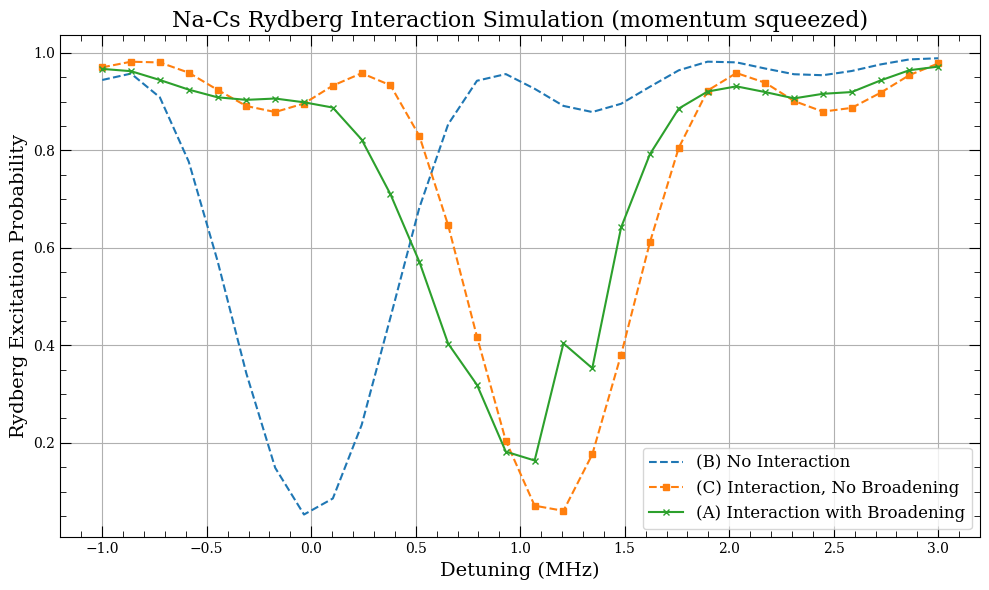

In [236]:
# ---------------------------------
# Main simulation
# ---------------------------------

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg_mom_squeeze, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

# (B) without interaction
start_time = time.time()
d, P_no = scan_detuning(cfg_mom_squeeze, c6_rad_um6=c6, interaction_on=False)
print(f"time for (B) without interaction: {time.time() - start_time:.1f} s")

# (C) without broadening
start_time = time.time()
d, P_no_broad = scan_detuning(ExperimentConfig(**{**cfg_mom_squeeze.__dict__, "broadening": False}), c6_rad_um6=c6, interaction_on=True)
print(f"time for (C) without broadening: {time.time() - start_time:.1f} s")

# (A) with interaction
start_time = time.time()
d, P_int_mom_squeeze = scan_detuning(cfg_mom_squeeze, c6_rad_um6=c6, interaction_on=True)
print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

print("Simulation done.")

# Plotting
plt.figure(figsize=(10,6))
plt.plot(d / 1e6, P_no, '--', label='(B) No Interaction', markersize=5)
plt.plot(d / 1e6, P_no_broad, 's--', label='(C) Interaction, No Broadening', markersize=5)
plt.plot(d / 1e6, P_int_mom_squeeze, 'x-', label='(A) Interaction with Broadening', markersize=5)
plt.xlabel('Detuning (MHz)', fontsize=14)
plt.ylabel('Rydberg Excitation Probability', fontsize=14)
plt.title('Na-Cs Rydberg Interaction Simulation (momentum squeezed)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

#### looking at position and momemntum distributions.

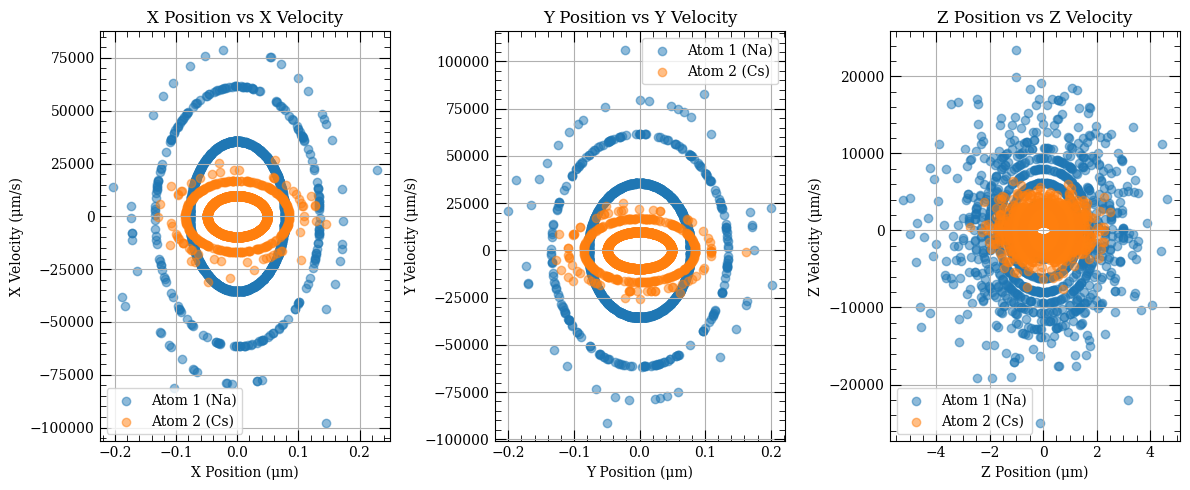

In [237]:
# plot positions and velocities of both atoms for each axis (x, y, z)

x_pos_um_atom1 = np.array(cfg_mom_squeeze.positions1_list)[:,0]
y_pos_um_atom1 = np.array(cfg_mom_squeeze.positions1_list)[:,1]
z_pos_um_atom1 = np.array(cfg_mom_squeeze.positions1_list)[:,2]
x_pos_um_atom2 = np.array(cfg_mom_squeeze.positions2_list)[:,0]
y_pos_um_atom2 = np.array(cfg_mom_squeeze.positions2_list)[:,1]
z_pos_um_atom2 = np.array(cfg_mom_squeeze.positions2_list)[:,2]
vx_um_per_s_atom1 = np.array(cfg_mom_squeeze.velocities1_list)[:,0]
vy_um_per_s_atom1 = np.array(cfg_mom_squeeze.velocities1_list)[:,1]
vz_um_per_s_atom1 = np.array(cfg_mom_squeeze.velocities1_list)[:,2]
vx_um_per_s_atom2 = np.array(cfg_mom_squeeze.velocities2_list)[:,0]
vy_um_per_s_atom2 = np.array(cfg_mom_squeeze.velocities2_list)[:,1]
vz_um_per_s_atom2 = np.array(cfg_mom_squeeze.velocities2_list)[:,2]

# # normalize the positions and velocities using min-max normalization for better visualization
# x_pos_um_atom1 = (x_pos_um_atom1 - np.min(x_pos_um_atom1)) / (np.max(x_pos_um_atom1) - np.min(x_pos_um_atom1))
# y_pos_um_atom1 = (y_pos_um_atom1 - np.min(y_pos_um_atom1)) / (np.max(y_pos_um_atom1) - np.min(y_pos_um_atom1))
# z_pos_um_atom1 = (z_pos_um_atom1 - np.min(z_pos_um_atom1)) / (np.max(z_pos_um_atom1) - np.min(z_pos_um_atom1))
# x_pos_um_atom2 = (x_pos_um_atom2 - np.min(x_pos_um_atom2)) / (np.max(x_pos_um_atom2) - np.min(x_pos_um_atom2))
# y_pos_um_atom2 = (y_pos_um_atom2 - np.min(y_pos_um_atom2)) / (np.max(y_pos_um_atom2) - np.min(y_pos_um_atom2))
# z_pos_um_atom2 = (z_pos_um_atom2 - np.min(z_pos_um_atom2)) / (np.max(z_pos_um_atom2) - np.min(z_pos_um_atom2))
# vx_um_per_s_atom1 = (vx_um_per_s_atom1 - np.min(vx_um_per_s_atom1)) / (np.max(vx_um_per_s_atom1) - np.min(vx_um_per_s_atom1))
# vy_um_per_s_atom1 = (vy_um_per_s_atom1 - np.min(vy_um_per_s_atom1)) / (np.max(vy_um_per_s_atom1) - np.min(vy_um_per_s_atom1))
# vz_um_per_s_atom1 = (vz_um_per_s_atom1 - np.min(vz_um_per_s_atom1)) / (np.max(vz_um_per_s_atom1) - np.min(vz_um_per_s_atom1))
# vx_um_per_s_atom2 = (vx_um_per_s_atom2 - np.min(vx_um_per_s_atom2)) / (np.max(vx_um_per_s_atom2) - np.min(vx_um_per_s_atom2))
# vy_um_per_s_atom2 = (vy_um_per_s_atom2 - np.min(vy_um_per_s_atom2)) / (np.max(vy_um_per_s_atom2) - np.min(vy_um_per_s_atom2))
# vz_um_per_s_atom2 = (vz_um_per_s_atom2 - np.min(vz_um_per_s_atom2)) / (np.max(vz_um_per_s_atom2) - np.min(vz_um_per_s_atom2))



# plot x position vs x velocity for both atoms
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(x_pos_um_atom1, vx_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(x_pos_um_atom2, vx_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('X Position (μm)')
plt.ylabel('X Velocity (μm/s)')
plt.title('X Position vs X Velocity')
plt.legend()
plt.grid()

# plot y position vs y velocity for both atoms
plt.subplot(1,3,2)
plt.scatter(y_pos_um_atom1, vy_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(y_pos_um_atom2, vy_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('Y Position (μm)')
plt.ylabel('Y Velocity (μm/s)')
plt.title('Y Position vs Y Velocity')
plt.legend()
plt.grid()

# plot z position vs z velocity for both atoms
plt.subplot(1,3,3)
plt.scatter(z_pos_um_atom1, vz_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(z_pos_um_atom2, vz_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('Z Position (μm)')
plt.ylabel('Z Velocity (μm/s)')
plt.title('Z Position vs Z Velocity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


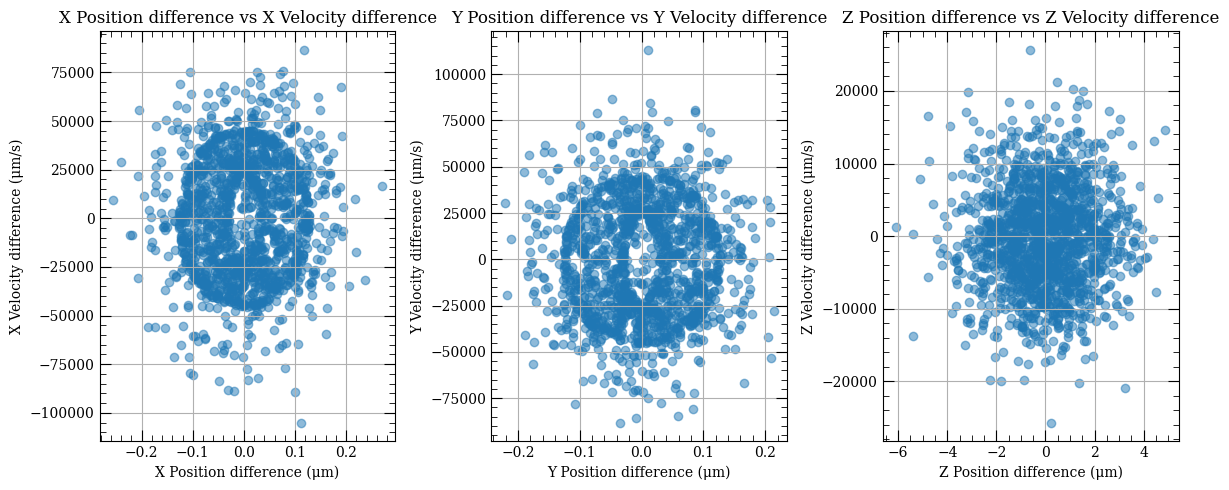

In [238]:
# plot cfg.positions_list vs cfg.velocities_list for (x,y,z)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
pos_x_mom_squeeze = np.array(cfg_mom_squeeze.positions_list)[:,0]
vel_x_mom_squeeze = np.array(cfg_mom_squeeze.velocities_list)[:,0]
# normalize pos_x and vel_x by their standard deviations
# pos_x = (pos_x - np.mean(pos_x)) / np.std(pos_x)
# vel_x = (vel_x - np.mean(vel_x)) / np.std(vel_x)
plt.scatter(pos_x_mom_squeeze, vel_x_mom_squeeze, label='', alpha=0.5)
plt.xlabel('X Position difference (μm)')
plt.ylabel('X Velocity difference (μm/s)')
plt.title('X Position difference vs X Velocity difference')
plt.grid()

plt.subplot(1,3,2)
pos_y_mom_squeeze = np.array(cfg_mom_squeeze.positions_list)[:,1]
vel_y_mom_squeeze = np.array(cfg_mom_squeeze.velocities_list)[:,1]
# normalize pos_y and vel_y by their standard deviations
# pos_y = (pos_y - np.mean(pos_y)) / np.std(pos_y)
# vel_y = (vel_y - np.mean(vel_y)) / np.std(vel_y)
plt.scatter(pos_y_mom_squeeze, vel_y_mom_squeeze, label='', alpha=0.5)
plt.xlabel('Y Position difference (μm)')
plt.ylabel('Y Velocity difference (μm/s)')
plt.title('Y Position difference vs Y Velocity difference')
plt.grid()

plt.subplot(1,3,3)
pos_z_mom_squeeze = np.array(cfg_mom_squeeze.positions_list)[:,2]
vel_z_mom_squeeze = np.array(cfg_mom_squeeze.velocities_list)[:,2]
# normalize pos_z and vel_z by their standard deviations
# pos_z = (pos_z - np.mean(pos_z)) / np.std(pos_z)
# vel_z = (vel_z - np.mean(vel_z)) / np.std(vel_z)
plt.scatter(pos_z_mom_squeeze, vel_z_mom_squeeze, label='', alpha=0.5)
plt.xlabel('Z Position difference (μm)')
plt.ylabel('Z Velocity difference (μm/s)')
plt.title('Z Position difference vs Z Velocity difference')
plt.grid()
plt.tight_layout()
plt.show()

#### now position squeeze (only radial)

In [239]:
# first checking without squeezing what is the position and momentum spread
pixel_to_um = 0.87 # imaging system calibration from Cs-Cs (Na-Cs gives ~ 0.87)
# pixel_to_um = 0.87
factor = 1/0.25
# Experiment configuration
cfg_pos_squeeze = ExperimentConfig(
    R_mean_um = 6.5 * pixel_to_um,  # mean interatomic distance in microns
    R_axis_um = (1.0, 0.0, 0.0),  # along x-axis
    OMEGA_atom1_Hz = 5.0e5,  # Na Rabi frequency (Hz)
    OMEGA_atom2_Hz = 0,  # Cs Rabi frequency (Hz) [no Cs drive] - just prepare Cs in Rydberg

    Delta_scan_Hz = np.linspace(-1, 3, 30) * 1e6, # detuning scan range (Hz)

    # Order: (x, y, z). (radial, radial, axial)
    # These are the *ground-state* trap temps of each tweezer. (uK)
    T_uK_atom1 = (2.0, 2.0, 2.0), # 2.0
    T_uK_atom2 = (1.0, 1.0, 1.0), # 1.0

    # These are the *ground-state* trap frequencies of each tweezer. (loading depth)
    omega_trap_atom1_Hz = (230e3, 230e3, 37e3), # using values from ryan 29Oct
    omega_trap_atom2_Hz = (100e3, 100e3, 20e3),

    load_factor = np.sqrt(0.1),  # % of trap depth after dropping

    T2_atom1_s = 5e-6, # coherence time for Na
    T2_atom2_s = 20e-6, # coherence time for Cs
    T1_use_ARC = True, # whether to use ARC lifetimes for T1

    broadening = True, # turn on or off broadening
    N_mc = 50,  # number of Monte Carlo samples per detuning
    N_steps = 20,  # number of time steps in evolution

    load_depth_T_atom1 = 350, # uK
    load_depth_T_atom2 = 100, # uK

    plot_displacements = False,  # whether to plot displacement histogram
    simulate_atom1_recapture=True,
    simulate_atom2_recapture=True,

    squeeze_factor = (1.0, 1.0, factor),  # squeezing factor for each axis(1 = no squeezing)
)

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg_pos_squeeze, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s


Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s
Starting detuning scan...
  Point 2/30 - Elapsed: 0.0s, Est. remaining: 0.7s
  Point 4/30 - Elapsed: 0.1s, Est. remaining: 0.9s
  Point 6/30 - Elapsed: 0.2s, Est. remaining: 1.0s
  Point 8/30 - Elapsed: 0.3s, Est. remaining: 0.9s
  Point 10/30 - Elapsed: 0.4s, Est. remaining: 0.9s
  Point 12/30 - Elapsed: 0.5s, Est. remaining: 0.8s
  Point 14/30 - Elapsed: 0.6s, Est. remaining: 0.7s
  Point 16/30 - Elapsed: 0.7s, Est. remaining: 0.6s
  Point 18/30 - Elapsed: 0.8s, Est. remaining: 0.5s
  Point 20/30 - Elapsed: 0.9s, Est. remaining: 0.5s
  Point 22/30 - Elapsed: 1.0s, Est. remaining: 0.4s
  Point 24/30 - Elapsed: 1.1s, Est. remaining: 0.3s
  Point 26/30 - Elapsed: 1.2s, Est. remaining: 0.2s
  Point 28/30 - Elapsed: 1.3s, Est. remaining: 0.1s
  Point 30/30 - Elapsed: 1.4s, Est. remaining: 0.0s
time for (B) without interaction: 1.5 s
Sta

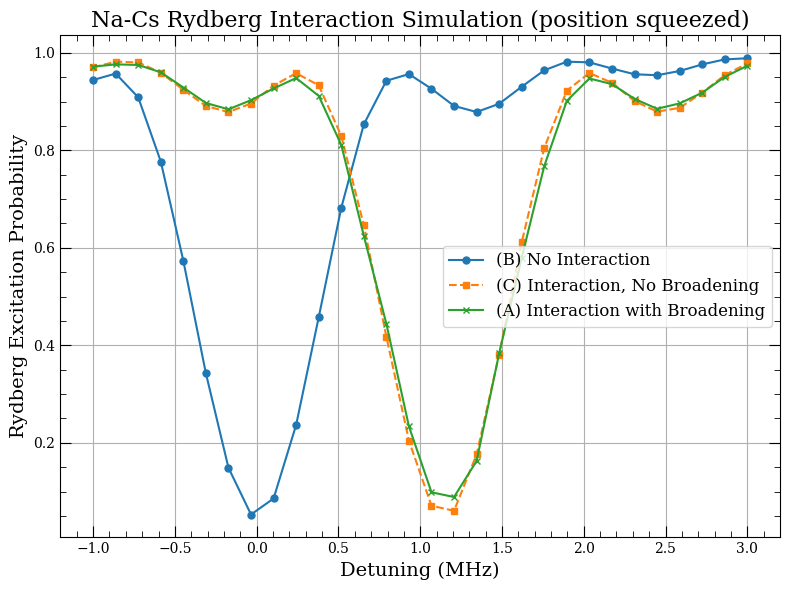

In [240]:
# ---------------------------------
# Main simulation
# ---------------------------------

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg_pos_squeeze, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

# (B) without interaction
start_time = time.time()
d, P_no = scan_detuning(cfg_pos_squeeze, c6_rad_um6=c6, interaction_on=False)
print(f"time for (B) without interaction: {time.time() - start_time:.1f} s")

# (C) without broadening
start_time = time.time()
d, P_no_broad = scan_detuning(ExperimentConfig(**{**cfg_pos_squeeze.__dict__, "broadening": False}), c6_rad_um6=c6, interaction_on=True)
print(f"time for (C) without broadening: {time.time() - start_time:.1f} s")

# (A) with interaction
start_time = time.time()
d, P_int_pos_squeeze = scan_detuning(cfg_pos_squeeze, c6_rad_um6=c6, interaction_on=True)
print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

print("Simulation done.")

# Plotting
plt.figure(figsize=(8,6))
plt.plot(d / 1e6, P_no, 'o-', label='(B) No Interaction', markersize=5)
plt.plot(d / 1e6, P_no_broad, 's--', label='(C) Interaction, No Broadening', markersize=5)
plt.plot(d / 1e6, P_int_pos_squeeze, 'x-', label='(A) Interaction with Broadening', markersize=5)
plt.xlabel('Detuning (MHz)', fontsize=14)
plt.ylabel('Rydberg Excitation Probability', fontsize=14)
plt.title('Na-Cs Rydberg Interaction Simulation (position squeezed)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

#### looking at position and momemntum distributions.

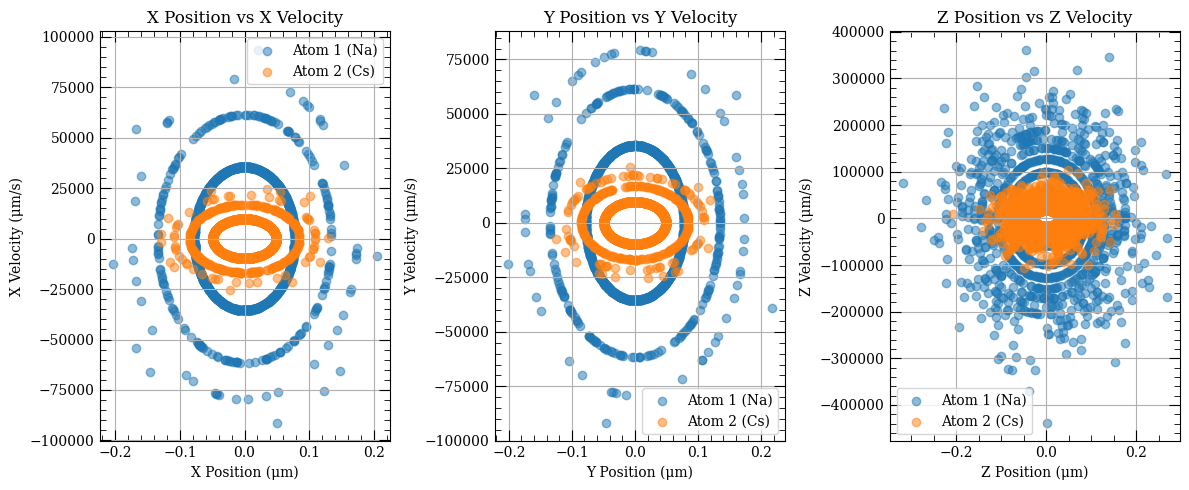

In [241]:
# plot positions and velocities of both atoms for each axis (x, y, z)

x_pos_um_atom1 = np.array(cfg_pos_squeeze.positions1_list)[:,0]
y_pos_um_atom1 = np.array(cfg_pos_squeeze.positions1_list)[:,1]
z_pos_um_atom1 = np.array(cfg_pos_squeeze.positions1_list)[:,2]
x_pos_um_atom2 = np.array(cfg_pos_squeeze.positions2_list)[:,0]
y_pos_um_atom2 = np.array(cfg_pos_squeeze.positions2_list)[:,1]
z_pos_um_atom2 = np.array(cfg_pos_squeeze.positions2_list)[:,2]
vx_um_per_s_atom1 = np.array(cfg_pos_squeeze.velocities1_list)[:,0]
vy_um_per_s_atom1 = np.array(cfg_pos_squeeze.velocities1_list)[:,1]
vz_um_per_s_atom1 = np.array(cfg_pos_squeeze.velocities1_list)[:,2]
vx_um_per_s_atom2 = np.array(cfg_pos_squeeze.velocities2_list)[:,0]
vy_um_per_s_atom2 = np.array(cfg_pos_squeeze.velocities2_list)[:,1]
vz_um_per_s_atom2 = np.array(cfg_pos_squeeze.velocities2_list)[:,2]

# # normalize the positions and velocities using min-max normalization for better visualization
# x_pos_um_atom1 = (x_pos_um_atom1 - np.min(x_pos_um_atom1)) / (np.max(x_pos_um_atom1) - np.min(x_pos_um_atom1))
# y_pos_um_atom1 = (y_pos_um_atom1 - np.min(y_pos_um_atom1)) / (np.max(y_pos_um_atom1) - np.min(y_pos_um_atom1))
# z_pos_um_atom1 = (z_pos_um_atom1 - np.min(z_pos_um_atom1)) / (np.max(z_pos_um_atom1) - np.min(z_pos_um_atom1))
# x_pos_um_atom2 = (x_pos_um_atom2 - np.min(x_pos_um_atom2)) / (np.max(x_pos_um_atom2) - np.min(x_pos_um_atom2))
# y_pos_um_atom2 = (y_pos_um_atom2 - np.min(y_pos_um_atom2)) / (np.max(y_pos_um_atom2) - np.min(y_pos_um_atom2))
# z_pos_um_atom2 = (z_pos_um_atom2 - np.min(z_pos_um_atom2)) / (np.max(z_pos_um_atom2) - np.min(z_pos_um_atom2))
# vx_um_per_s_atom1 = (vx_um_per_s_atom1 - np.min(vx_um_per_s_atom1)) / (np.max(vx_um_per_s_atom1) - np.min(vx_um_per_s_atom1))
# vy_um_per_s_atom1 = (vy_um_per_s_atom1 - np.min(vy_um_per_s_atom1)) / (np.max(vy_um_per_s_atom1) - np.min(vy_um_per_s_atom1))
# vz_um_per_s_atom1 = (vz_um_per_s_atom1 - np.min(vz_um_per_s_atom1)) / (np.max(vz_um_per_s_atom1) - np.min(vz_um_per_s_atom1))
# vx_um_per_s_atom2 = (vx_um_per_s_atom2 - np.min(vx_um_per_s_atom2)) / (np.max(vx_um_per_s_atom2) - np.min(vx_um_per_s_atom2))
# vy_um_per_s_atom2 = (vy_um_per_s_atom2 - np.min(vy_um_per_s_atom2)) / (np.max(vy_um_per_s_atom2) - np.min(vy_um_per_s_atom2))
# vz_um_per_s_atom2 = (vz_um_per_s_atom2 - np.min(vz_um_per_s_atom2)) / (np.max(vz_um_per_s_atom2) - np.min(vz_um_per_s_atom2))



# plot x position vs x velocity for both atoms
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(x_pos_um_atom1, vx_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(x_pos_um_atom2, vx_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('X Position (μm)')
plt.ylabel('X Velocity (μm/s)')
plt.title('X Position vs X Velocity')
plt.legend()
plt.grid()

# plot y position vs y velocity for both atoms
plt.subplot(1,3,2)
plt.scatter(y_pos_um_atom1, vy_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(y_pos_um_atom2, vy_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('Y Position (μm)')
plt.ylabel('Y Velocity (μm/s)')
plt.title('Y Position vs Y Velocity')
plt.legend()
plt.grid()

# plot z position vs z velocity for both atoms
plt.subplot(1,3,3)
plt.scatter(z_pos_um_atom1, vz_um_per_s_atom1, label='Atom 1 (Na)', alpha=0.5)
plt.scatter(z_pos_um_atom2, vz_um_per_s_atom2, label='Atom 2 (Cs)', alpha=0.5)
plt.xlabel('Z Position (μm)')
plt.ylabel('Z Velocity (μm/s)')
plt.title('Z Position vs Z Velocity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


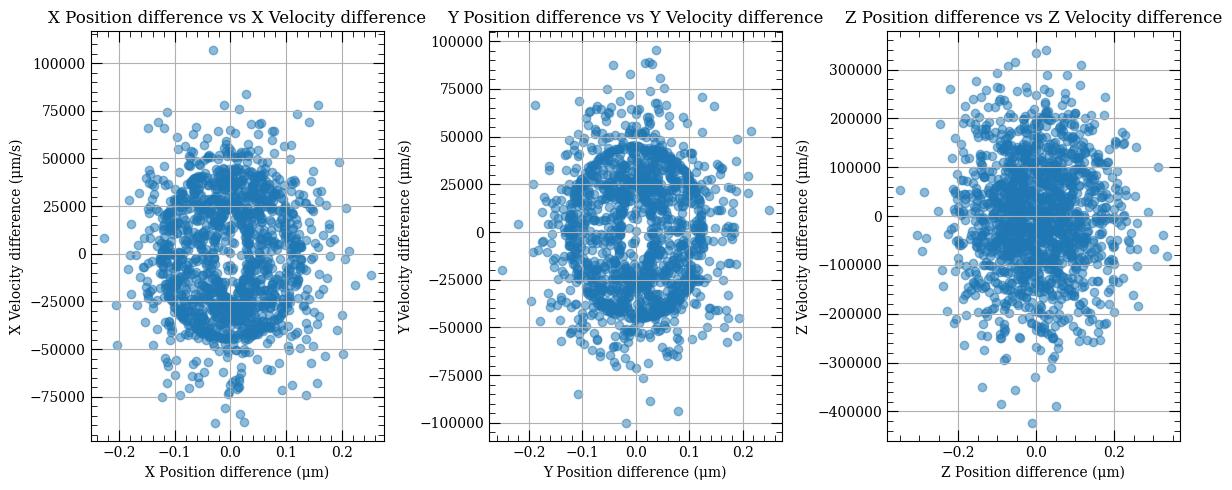

In [242]:
# plot cfg.positions_list vs cfg.velocities_list for (x,y,z)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
pos_x_pos_squeeze = np.array(cfg_pos_squeeze.positions_list)[:,0]
vel_x_pos_squeeze = np.array(cfg_pos_squeeze.velocities_list)[:,0]
# normalize pos_x and vel_x by their standard deviations
# pos_x = (pos_x - np.mean(pos_x)) / np.std(pos_x)
# vel_x = (vel_x - np.mean(vel_x)) / np.std(vel_x)
plt.scatter(pos_x_pos_squeeze, vel_x_pos_squeeze, label='', alpha=0.5)
plt.xlabel('X Position difference (μm)')
plt.ylabel('X Velocity difference (μm/s)')
plt.title('X Position difference vs X Velocity difference')
plt.grid()

plt.subplot(1,3,2)
pos_y_pos_squeeze = np.array(cfg_pos_squeeze.positions_list)[:,1]
vel_y_pos_squeeze = np.array(cfg_pos_squeeze.velocities_list)[:,1]
# normalize pos_y and vel_y by their standard deviations
# pos_y = (pos_y - np.mean(pos_y)) / np.std(pos_y)
# vel_y = (vel_y - np.mean(vel_y)) / np.std(vel_y)
plt.scatter(pos_y_pos_squeeze, vel_y_pos_squeeze, label='', alpha=0.5)
plt.xlabel('Y Position difference (μm)')
plt.ylabel('Y Velocity difference (μm/s)')
plt.title('Y Position difference vs Y Velocity difference')
plt.grid()

plt.subplot(1,3,3)
pos_z_pos_squeeze = np.array(cfg_pos_squeeze.positions_list)[:,2]
vel_z_pos_squeeze = np.array(cfg_pos_squeeze.velocities_list)[:,2]
# normalize pos_z and vel_z by their standard deviations
# pos_z = (pos_z - np.mean(pos_z)) / np.std(pos_z)
# vel_z = (vel_z - np.mean(vel_z)) / np.std(vel_z)
plt.scatter(pos_z_pos_squeeze, vel_z_pos_squeeze, label='', alpha=0.5)
plt.xlabel('Z Position difference (μm)')
plt.ylabel('Z Velocity difference (μm/s)')
plt.title('Z Position difference vs Z Velocity difference')
plt.grid()
plt.tight_layout()
plt.show()

### Plotting all of them for comparison

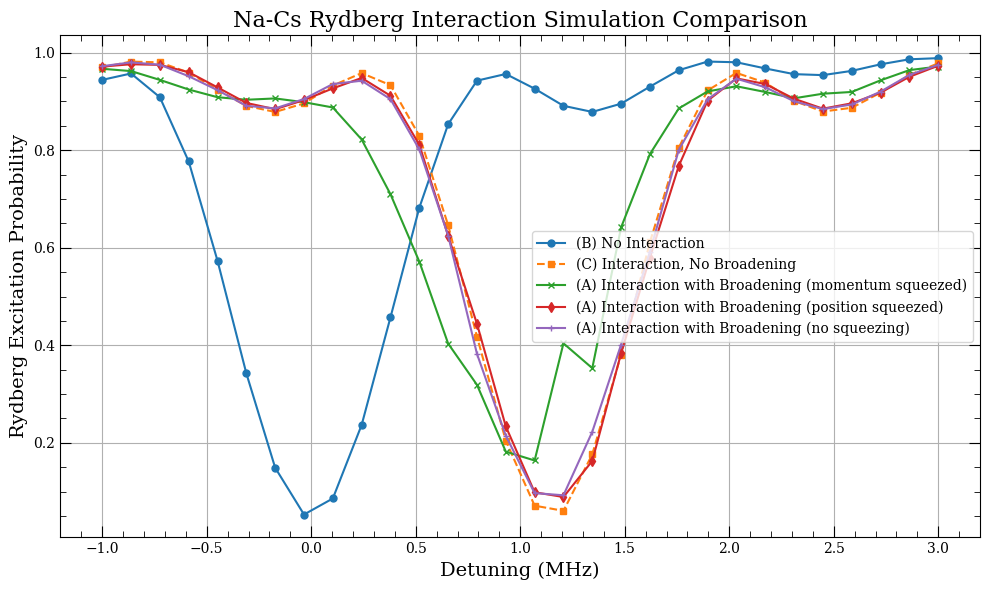

In [247]:
# plot no squeezing, momentum squeezing, and position squeezing all together for comparison
plt.figure(figsize=(10,6))
plt.plot(d / 1e6, P_no, 'o-', label='(B) No Interaction', markersize=5)
plt.plot(d / 1e6, P_no_broad, 's--', label='(C) Interaction, No Broadening', markersize=5)
plt.plot(d / 1e6, P_int_mom_squeeze, 'x-', label='(A) Interaction with Broadening (momentum squeezed)', markersize=5)
plt.plot(d / 1e6, P_int_pos_squeeze, 'd-', label='(A) Interaction with Broadening (position squeezed)', markersize=5)
plt.plot(d / 1e6, P_int, '+-', label='(A) Interaction with Broadening (no squeezing)', markersize=5)
plt.xlabel('Detuning (MHz)', fontsize=14)
plt.ylabel('Rydberg Excitation Probability', fontsize=14)
plt.title('Na-Cs Rydberg Interaction Simulation Comparison', fontsize=16)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

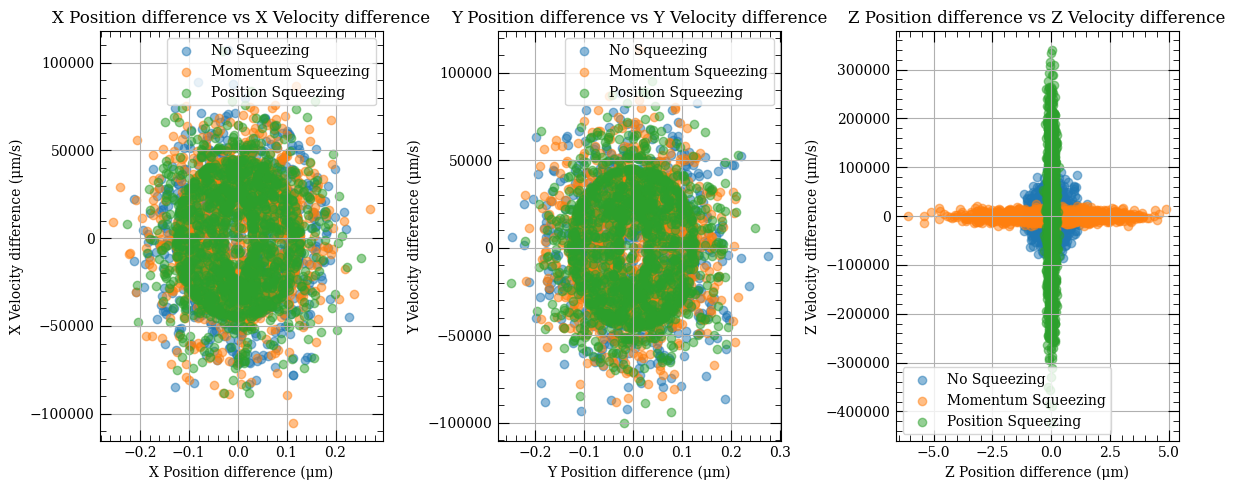

In [248]:
# plot pos vs vel for no squeezing, momentum squeezing, and position squeezing for x axis only
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(pos_x_no_squeeze, vel_x_no_squeeze, label='No Squeezing', alpha=0.5)
plt.scatter(pos_x_mom_squeeze, vel_x_mom_squeeze, label='Momentum Squeezing', alpha=0.5)
plt.scatter(pos_x_pos_squeeze, vel_x_pos_squeeze, label='Position Squeezing', alpha=0.5)
plt.xlabel('X Position difference (μm)')
plt.ylabel('X Velocity difference (μm/s)')
plt.title('X Position difference vs X Velocity difference')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.scatter(pos_y_no_squeeze, vel_y_no_squeeze, label='No Squeezing', alpha=0.5)
plt.scatter(pos_y_mom_squeeze, vel_y_mom_squeeze, label='Momentum Squeezing', alpha=0.5)
plt.scatter(pos_y_pos_squeeze, vel_y_pos_squeeze, label='Position Squeezing', alpha=0.5)
plt.xlabel('Y Position difference (μm)')
plt.ylabel('Y Velocity difference (μm/s)')
plt.title('Y Position difference vs Y Velocity difference')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.scatter(pos_z_no_squeeze, vel_z_no_squeeze, label='No Squeezing', alpha=0.5)
plt.scatter(pos_z_mom_squeeze, vel_z_mom_squeeze, label='Momentum Squeezing', alpha=0.5)
plt.scatter(pos_z_pos_squeeze, vel_z_pos_squeeze, label='Position Squeezing', alpha=0.5)
plt.xlabel('Z Position difference (μm)')
plt.ylabel('Z Velocity difference (μm/s)')
plt.title('Z Position difference vs Z Velocity difference')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Release recapture comparison.

#### no squeezing

Starting detuning scan...
time for (A) with interaction: 0.2 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.2 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction

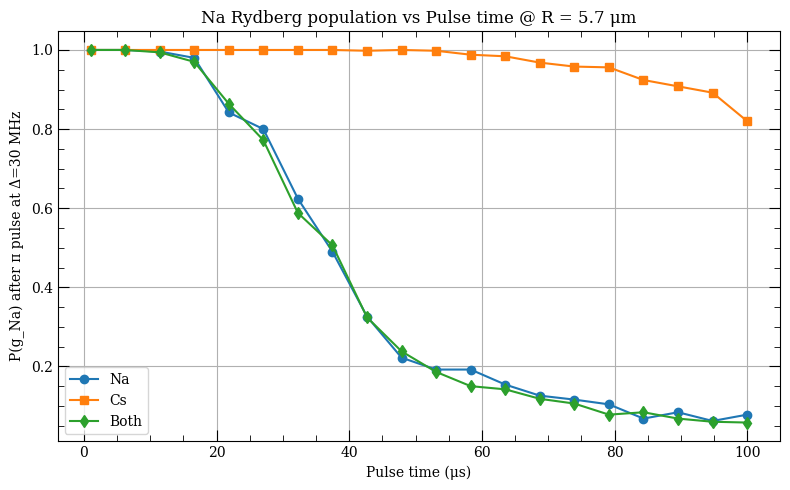

In [249]:
cfg_no_squeeze.hamiltonian_on = False
cfg_no_squeeze.Delta_scan_Hz = np.array([1e6]), # single detuning value (Hz)
cfg_no_squeeze.OMEGA_atom1_Hz = 0  # Na Rabi frequency (Hz)
cfg_no_squeeze.OMEGA_atom2_Hz = 0  # Cs Rabi frequency (Hz)
cfg_no_squeeze.N_mc = 500
cfg_no_squeeze.N_steps = 100

# sweep over pulse times (Rabi frequencies)
pulse_times_us = np.linspace(1, 100, 20)  # in microseconds
colors = plt.cm.viridis(np.linspace(0, 1, len(pulse_times_us)))

# first only Na release curve vs pulse time (no squeezing)
cfg_no_squeeze.simulate_atom1_recapture = True
cfg_no_squeeze.simulate_atom2_recapture = False

# rabi_freqs_Hz = (np.pi / (2 * (pulse_times_us * 1e-6)))  # in Hz
pop_array_Na_no_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_no_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()
    
    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_no_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Na_no_squeeze.append(P_int[0])  # only one detuning point

# now for Cs release curve vs pulse time (no squeezing)
cfg_no_squeeze.simulate_atom1_recapture = False
cfg_no_squeeze.simulate_atom2_recapture = True

pop_array_Cs_no_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_no_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_no_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Cs_no_squeeze.append(P_int[0])  # only one detuning point

# now both atoms recapture vs pulse time (no squeezing)
cfg_no_squeeze.simulate_atom1_recapture = True
cfg_no_squeeze.simulate_atom2_recapture = True
pop_array_both_no_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_no_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_no_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_both_no_squeeze.append(P_int[0])  # only one detuning point

# plot pulse time vs population
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us, np.array(pop_array_Na_no_squeeze), "o-", label="Na")
plt.plot(pulse_times_us, np.array(pop_array_Cs_no_squeeze), "s-", label="Cs")
plt.plot(pulse_times_us, np.array(pop_array_both_no_squeeze), "d-", label="Both")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g_Na) after π pulse at Δ=30 MHz")
plt.title(f"Na Rydberg population vs Pulse time @ R = {cfg_no_squeeze.R_mean_um:.1f} μm")
# set x-axis to log scale
# plt.xscale("log")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### momentum squeezed.

Starting detuning scan...
time for (A) with interaction: 0.2 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.2 s
Starting detuning scan...
time for (A) with interaction: 0.2 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction

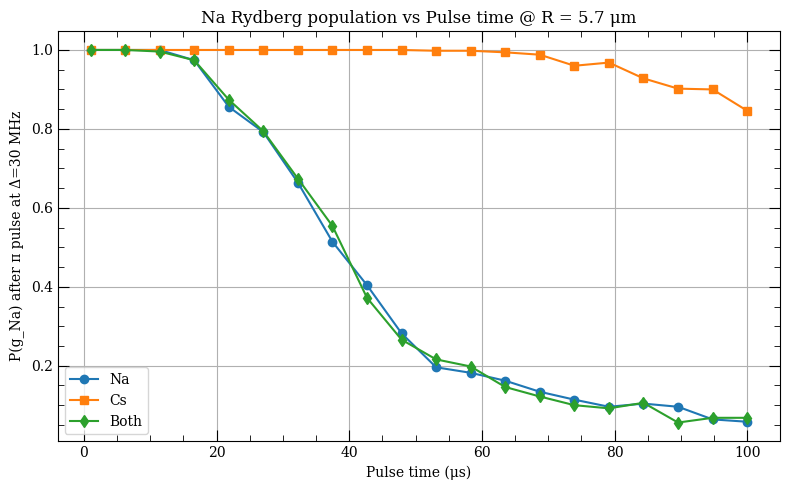

In [250]:
cfg_mom_squeeze.hamiltonian_on = False
cfg_mom_squeeze.Delta_scan_Hz = np.array([1e6]), # single detuning value (Hz)
cfg_mom_squeeze.OMEGA_atom1_Hz = 0  # Na Rabi frequency (Hz)
cfg_mom_squeeze.OMEGA_atom2_Hz = 0  # Cs Rabi frequency (Hz)
cfg_mom_squeeze.N_mc = 500
cfg_mom_squeeze.N_steps = 100

# sweep over pulse times (Rabi frequencies)
pulse_times_us = np.linspace(1, 100, 20)  # in microseconds
colors = plt.cm.viridis(np.linspace(0, 1, len(pulse_times_us)))

# first only Na release curve vs pulse time (no squeezing)
cfg_mom_squeeze.simulate_atom1_recapture = True
cfg_mom_squeeze.simulate_atom2_recapture = False

# rabi_freqs_Hz = (np.pi / (2 * (pulse_times_us * 1e-6)))  # in Hz
pop_array_Na_mom_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_mom_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()
    
    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_mom_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Na_mom_squeeze.append(P_int[0])  # only one detuning point

# now for Cs release curve vs pulse time (no squeezing)
cfg_mom_squeeze.simulate_atom1_recapture = False
cfg_mom_squeeze.simulate_atom2_recapture = True

pop_array_Cs_mom_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_mom_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_mom_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Cs_mom_squeeze.append(P_int[0])  # only one detuning point

# now both atoms recapture vs pulse time (no squeezing)
cfg_mom_squeeze.simulate_atom1_recapture = True
cfg_mom_squeeze.simulate_atom2_recapture = True
pop_array_both_mom_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_mom_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_mom_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_both_mom_squeeze.append(P_int[0])  # only one detuning point

# plot pulse time vs population
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us, np.array(pop_array_Na_mom_squeeze), "o-", label="Na")
plt.plot(pulse_times_us, np.array(pop_array_Cs_mom_squeeze), "s-", label="Cs")
plt.plot(pulse_times_us, np.array(pop_array_both_mom_squeeze), "d-", label="Both")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g_Na) after π pulse at Δ=30 MHz")
plt.title(f"Na Rydberg population vs Pulse time @ R = {cfg_no_squeeze.R_mean_um:.1f} μm")
# set x-axis to log scale
# plt.xscale("log")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Position squeezed.

Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction

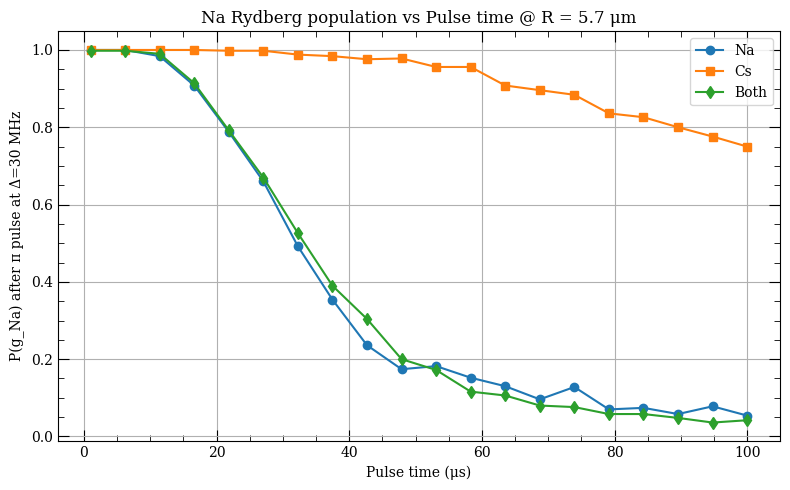

In [251]:
cfg_pos_squeeze.hamiltonian_on = False
cfg_pos_squeeze.Delta_scan_Hz = np.array([1e6]), # single detuning value (Hz)
cfg_pos_squeeze.OMEGA_atom1_Hz = 0  # Na Rabi frequency (Hz)
cfg_pos_squeeze.OMEGA_atom2_Hz = 0  # Cs Rabi frequency (Hz)
cfg_pos_squeeze.N_mc = 500
cfg_pos_squeeze.N_steps = 100

# sweep over pulse times (Rabi frequencies)
pulse_times_us = np.linspace(1, 100, 20)  # in microseconds
colors = plt.cm.viridis(np.linspace(0, 1, len(pulse_times_us)))

# first only Na release curve vs pulse time (no squeezing)
cfg_pos_squeeze.simulate_atom1_recapture = True
cfg_pos_squeeze.simulate_atom2_recapture = False

# rabi_freqs_Hz = (np.pi / (2 * (pulse_times_us * 1e-6)))  # in Hz
pop_array_Na_pos_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_pos_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()
    
    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_pos_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Na_pos_squeeze.append(P_int[0])  # only one detuning point

# now for Cs release curve vs pulse time (no squeezing)
cfg_pos_squeeze.simulate_atom1_recapture = False
cfg_pos_squeeze.simulate_atom2_recapture = True

pop_array_Cs_pos_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_pos_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_pos_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Cs_pos_squeeze.append(P_int[0])  # only one detuning point

# now both atoms recapture vs pulse time (no squeezing)
cfg_pos_squeeze.simulate_atom1_recapture = True
cfg_pos_squeeze.simulate_atom2_recapture = True
pop_array_both_pos_squeeze = []
for pulse_time, color in zip(pulse_times_us, colors):
    cfg_pos_squeeze.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()

    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg_pos_squeeze, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_both_pos_squeeze.append(P_int[0])  # only one detuning point

# plot pulse time vs population
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us, np.array(pop_array_Na_pos_squeeze), "o-", label="Na")
plt.plot(pulse_times_us, np.array(pop_array_Cs_pos_squeeze), "s-", label="Cs")
plt.plot(pulse_times_us, np.array(pop_array_both_pos_squeeze), "d-", label="Both")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g_Na) after π pulse at Δ=30 MHz")
plt.title(f"Na Rydberg population vs Pulse time @ R = {cfg_no_squeeze.R_mean_um:.1f} μm")
# set x-axis to log scale
# plt.xscale("log")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### comparison plot

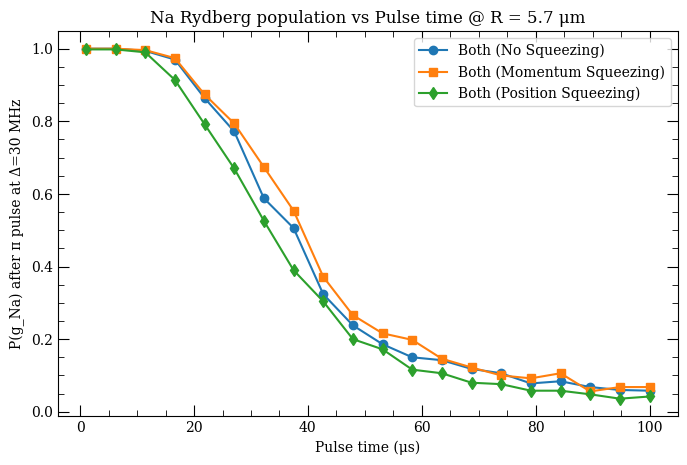

In [252]:
# plot a comparison of all three release curves for Na, Cs, and both atoms
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us, np.array(pop_array_both_no_squeeze), "o-", label="Both (No Squeezing)")
plt.plot(pulse_times_us, np.array(pop_array_both_mom_squeeze), "s-", label="Both (Momentum Squeezing)")
plt.plot(pulse_times_us, np.array(pop_array_both_pos_squeeze), "d-", label="Both (Position Squeezing)")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g_Na) after π pulse at Δ=30 MHz")
plt.title(f"Na Rydberg population vs Pulse time @ R = {cfg_no_squeeze.R_mean_um:.1f} μm")
plt.legend()
plt.show()